In [1]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter
import matplotlib.cm as cm
#from mpl_toolkits.mplot3d import Axes3D

from copy import deepcopy as dcopy

from scipy.fft import fft,fftfreq,fftshift,fft2,rfft,rfft2,rfftfreq,dct,dctn
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter,boxcar,blackman,hann,triang,resample,correlate,find_peaks,peak_widths,peak_prominences,correlate2d,fftconvolve
from scipy import interpolate

import numpy as np

#import plotly
#import plotly.graph_objs as go
#import plotly.express as px
#plotly.offline.init_notebook_mode()
import pandas as pd

import skimage.io as skio
from skimage.draw import circle_perimeter
from skimage.filters import window

from moisan2011 import per

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = [
r'\usepackage{tgheros}', # helvetica font
r'\usepackage{sansmath}', # math-font matching helvetica\n",
r'\sansmath' # actually tell tex to use it!\n",
r'\usepackage[scientific-notation=false]{siunitx}', # micro symbols\n",
r'\sisetup{detect-all}', # force siunitx to use the fonts
]

/Users/matthieu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


In [2]:
def circleAngleFunc(X,Y):
    if (X<0):
        return np.pi+np.arctan(Y/X)
    else:
        if (Y<0):
            return 2*np.pi+np.arctan(Y/X)
        else:
            return np.arctan(Y/X)

In [3]:
# Zero-padding of the signal signal
def padarray(A):
    log2_DataSize=np.log(A.size)/np.log(2)
    nextnext2power_DataSize=2**(np.ceil(log2_DataSize)+1)
    t = nextnext2power_DataSize - A.size
    return np.pad(A, pad_width=(int(np.floor(t/2)), int(np.ceil(t/2))), mode='constant')

In [4]:
def LinearFit(x,A):
    return A*x

In [5]:
def normalDistFit(x,A,B,C):
    return A*np.exp(-1/2*((x-C)**2/B))

In [6]:
def cauchyDistFit(x,A,s,m):
    return A*s**2/((x-m)**2+s**2)

# C'est parti!

Le film traité est obtenu de la façon suivante, sous **ImageJ/FiJi**:
1. ouverture du stack complet
2. reslice le long d'un diamètre de la tâche pour voir quand ce diamètre atteint un régime quasi-stationnaire
3. réduction du film à la gamme de slices vérifiant la condition précédente
4. extraction, puis inversion d'une des premières images du stack où l'écoulement n'a pas démarré
5. Inversion de cette image
6. Calcul de la moyenne de chaque image du stack obtenu à l'étape 3 avec l'image obtenue à l'étape 5.
7. BOOM :) (on peut retravailler le contraste)

On utilise aussi l'image de l'étape 3 et le reslice pour estimer le centre du cercle selon lequel on va capturer l'intensité et son rayon.

In [7]:
imstack1 = skio.imread('./AVGCENTERED127EXT_20201207_TTAB_c0p2molpL_emulsion_60huile40TA_Qps0p50mLpmin_h20mm_T19p5deg_f10Hz_texp0p01_n00_0059 20-12-07 10-24_2700-3700.tif', plugin='tifffile')

In [8]:
imstack1_avg=skio.imread('./AVGEXT_Result of 20201207_TTAB_c0p2molpL_emulsion_60huile40TA_Qps0p50mLpmin_h20mm_T19p5deg_f10Hz_texp0p01_n00_0059 20-12-07 10-24_2700-3700.tif',plugin='tifffile' )

In [9]:
# Définition de l'échelle spatiale. Nécessaire au moins pour la FFT
spatial_Scale=11e-3/37
marangoni_Radius=154 # Déterminé avec ImageJ

Text(0.5, 1.0, 'Original image')

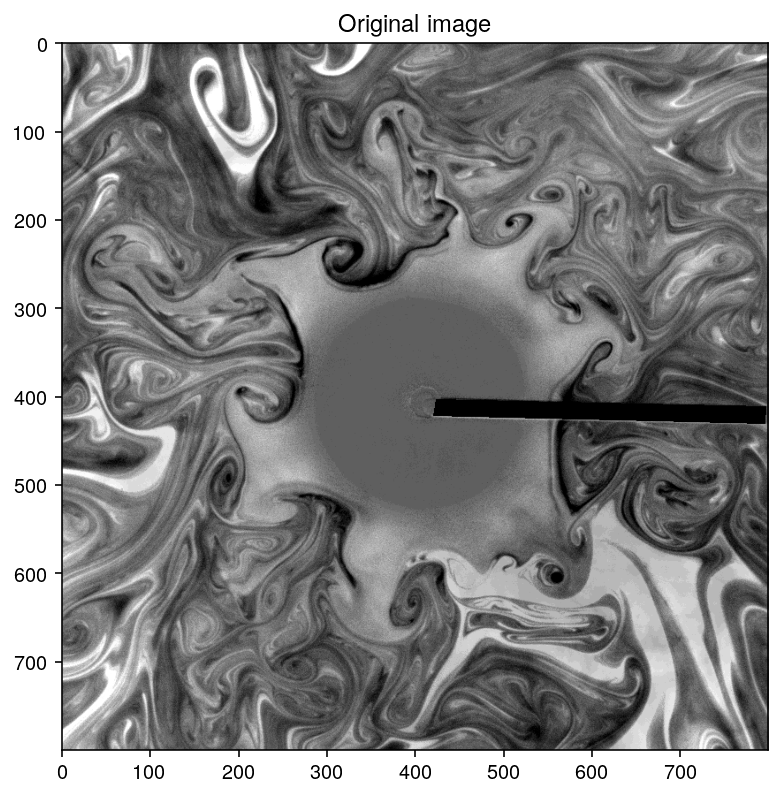

In [15]:
imageShow_fig,imageShow_ax=plt.subplots(1,1,figsize=[6.5,6.5])
imageShow_ax.imshow(imstack1[1],cmap='gray')
imageShow_ax.set_title('Original image')


Text(0.5, 1.0, 'Original image')

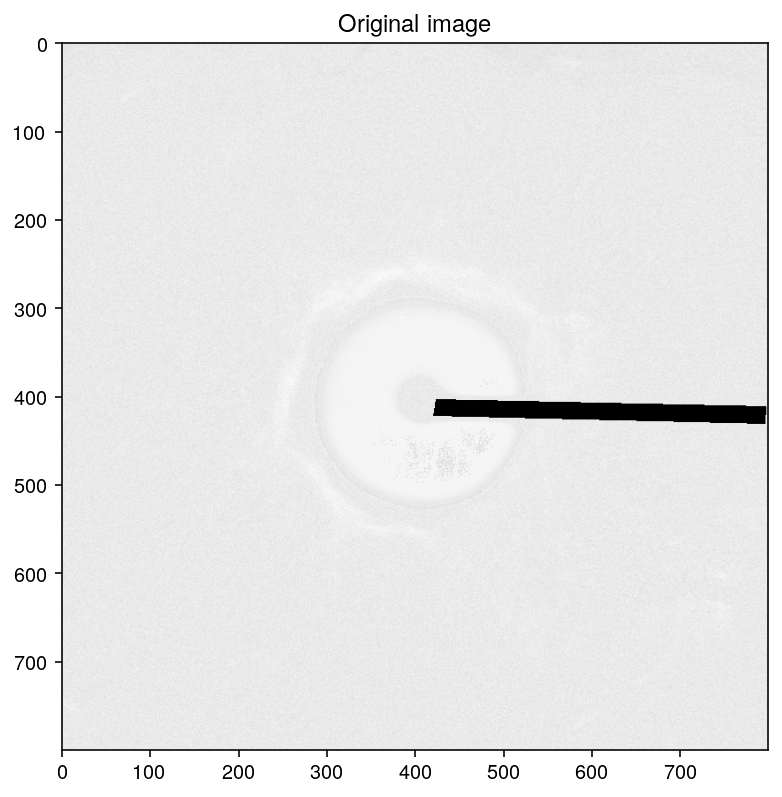

In [16]:
imageShow_fig2,imageShow_ax2=plt.subplots(1,1,figsize=[6.5,6.5])
imageShow_ax2.imshow(imstack1_avg,cmap='gray')
imageShow_ax2.set_title('Original image')


In [17]:
del imageShow_fig,imageShow_ax,imageShow_fig2,imageShow_ax2

### Systématisation
On va définir une gamme de rayons, qui définiront les cercles permettant de reconstruire la zone tourbillonaire

In [18]:
interpKnotNumber=513
kymoSize=len(imstack1)
kymoSize

1001

In [19]:
imstack1[1].shape

(800, 800)

**NOTE :** il fau jouer avec les paramètres ci-dessous pour bien positionner les cercles qui apparaissent sur l'image 3 cellules dessous.

In [20]:
circleRadius_range=np.linspace(marangoni_Radius-40,marangoni_Radius+210,251)
center_line=imstack1[0].shape[0]-(392) #Y position of circle center
center_column=imstack1[1].shape[0]-(395) #X position of circle center
angleSplineInterp = np.linspace(0, 2*np.pi, interpKnotNumber)

In [21]:
angularScale=2*np.pi/interpKnotNumber

In [24]:
imCopy1=dcopy(imstack1[1])
rrows_RM1, ccolumns_RM1=circle_perimeter(center_line,center_column,int(circleRadius_range[0]))
rrows_RM2, ccolumns_RM2=circle_perimeter(center_line,center_column,int(circleRadius_range[-1]))
imCopy1[rrows_RM1, ccolumns_RM1]=250
imCopy1[rrows_RM2, ccolumns_RM2]=250


In [25]:
imAvgCopy1=dcopy(imstack1_avg)
rrows_RM1, ccolumns_RM1=circle_perimeter(center_line,center_column,int(circleRadius_range[0]))
rrows_RM2, ccolumns_RM2=circle_perimeter(center_line,center_column,int(circleRadius_range[-1]))
imAvgCopy1[rrows_RM1, ccolumns_RM1]=250
imAvgCopy1[rrows_RM2, ccolumns_RM2]=250


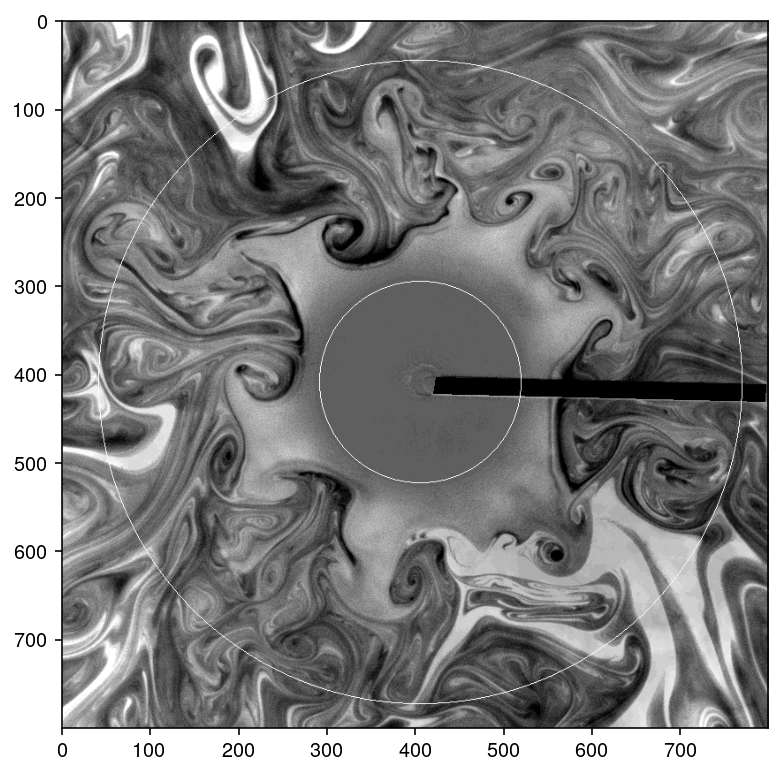

In [26]:
imageShow_fig2,imageShow_ax2=plt.subplots(1,1,figsize=[6.5,6.5])
imageShow_ax2.imshow(imCopy1,cmap='gray')
#imageShow_ax22.imshow(imCopy2,cmap='viridis')

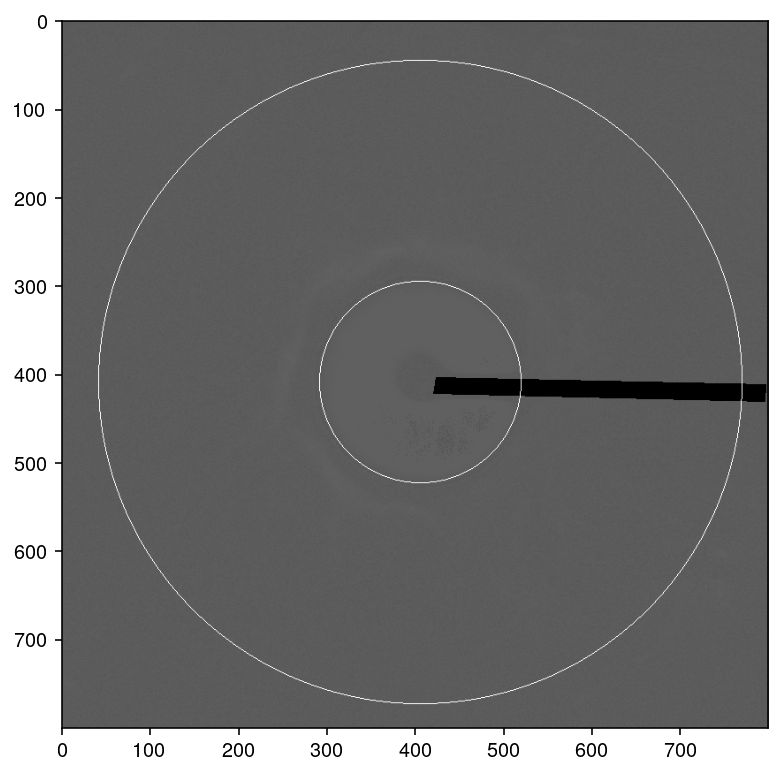

In [27]:
imageShow_fig3,imageShow_ax3=plt.subplots(1,1,figsize=[6.5,6.5])
imageShow_ax3.imshow(imAvgCopy1,cmap='gray')
#imageShow_ax22.imshow(imCopy2,cmap='viridis')

In [29]:
Corr_AngleLag=np.linspace(-interpKnotNumber+1,interpKnotNumber-1,2*interpKnotNumber-1)*2*np.pi/interpKnotNumber
grayvalueSplineInterp_ZT=np.zeros((len(circleRadius_range),interpKnotNumber))
grayvalueSplineInterp_ZT.shape
#print(str(2*np.pi))

(251, 513)

In [30]:
for i in range(0,len(circleRadius_range)):
    #print(i)
    rrows_ZT=[]
    ccolumns_ZT=[]
    circleIntensity_ZT=[]
    circleIntensity_mean_ZT=[]
    circleIntensity_noOffset_ZT=[]
    circle_Xpos_ZT=[]
    circle_Ypos_ZT=[]
    circle_Angle_ZT=[]
    df_ZT=[]
    sorted_AngleResults_ZT=[]
    index_ZT=[]
    angle_LinFit_popt_ZT=[]
    angle_LinFit_pcov_ZT=[]
    grayValue_Resampled_ZT=[]
    circle_perimeter_pix_ideal_ZT=[]
    grayValue_ResampledIndex_ZT=[]
    grayValue_ResampledAngle_ZT=[]
    tck_ZT =[]
    
    circle_perimeter_pix_ideal_ZT=2*np.pi*circleRadius_range[i]
    rrows_ZT, ccolumns_ZT = circle_perimeter(center_line,center_column,int(circleRadius_range[i]))
    circleIntensity_ZT=imstack1[15][rrows_ZT,ccolumns_ZT]
    circleIntensity_mean_ZT=127
    circleIntensity_noOffset_ZT=circleIntensity_ZT-circleIntensity_mean_ZT
    
    circle_Xpos_ZT=ccolumns_ZT-center_column
    circle_Ypos_ZT=rrows_ZT-center_line
    circle_Angle_ZT=[circleAngleFunc(circle_Xpos_ZT[j],circle_Ypos_ZT[j]) for j in range(0,len(circle_Xpos_ZT))]
    #df_ZT = pd.DataFrame({'X': circle_Xpos_ZT,'Y':circle_Ypos_ZT,'Angle': circle_Angle_ZT,'Gray Value':circleIntensity_noOffset_ZT})
    df_ZT = pd.DataFrame({'X': circle_Xpos_ZT,'Y':circle_Ypos_ZT,'Angle': circle_Angle_ZT,'Gray Value':circleIntensity_ZT})
    sorted_AngleResults_ZT=df_ZT.sort_values(by=['Angle'],ignore_index=True)
    #sorted_AngleResults_ZT_offset=df_ZT_offset.sort_values(by=['Angle'],ignore_index=True)
    index_ZT=np.linspace(0,sorted_AngleResults_ZT['X'].size-1,sorted_AngleResults_ZT['X'].size)
    angle_LinFit_popt_ZT,angle_LinFit_pcov_ZT=curve_fit(LinearFit,index_ZT,sorted_AngleResults_ZT['Angle'])
    grayValue_Resampled_ZT=resample(sorted_AngleResults_ZT['Gray Value'],int(circle_perimeter_pix_ideal_ZT))
    grayValue_ResampledIndex_ZT=np.linspace(0,sorted_AngleResults_ZT['X'].size-1,int(circle_perimeter_pix_ideal_ZT))
    grayValue_ResampledAngle_ZT=LinearFit(grayValue_ResampledIndex_ZT,*angle_LinFit_popt_ZT)
    
    tck_ZT = interpolate.splrep(grayValue_ResampledAngle_ZT,grayValue_Resampled_ZT, s=0)
    #grayvalueSplineInterp_ZT[i,:] = interpolate.splev(angleSplineInterp, tck_ZT, der=0)
    grayvalueSplineInterp_ZT[i,:] = np.where(interpolate.splev(angleSplineInterp, tck_ZT, der=0)<10,0,interpolate.splev(angleSplineInterp, tck_ZT, der=0))
    # L'image qui sort ici n'est plus traitée vis à vis de sa moyenne. Ainsi l'aiguille reste à 0 grâce à la dernière ligne. 
    del rrows_ZT,ccolumns_ZT,circleIntensity_ZT,circleIntensity_mean_ZT,circleIntensity_noOffset_ZT,circle_Xpos_ZT
    del circle_Ypos_ZT,circle_Angle_ZT,df_ZT,sorted_AngleResults_ZT,index_ZT,angle_LinFit_popt_ZT,angle_LinFit_pcov_ZT
    del grayValue_Resampled_ZT,circle_perimeter_pix_ideal_ZT,grayValue_ResampledIndex_ZT,grayValue_ResampledAngle_ZT,tck_ZT

/Users/matthieu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/Users/matthieu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in long_scalars
  


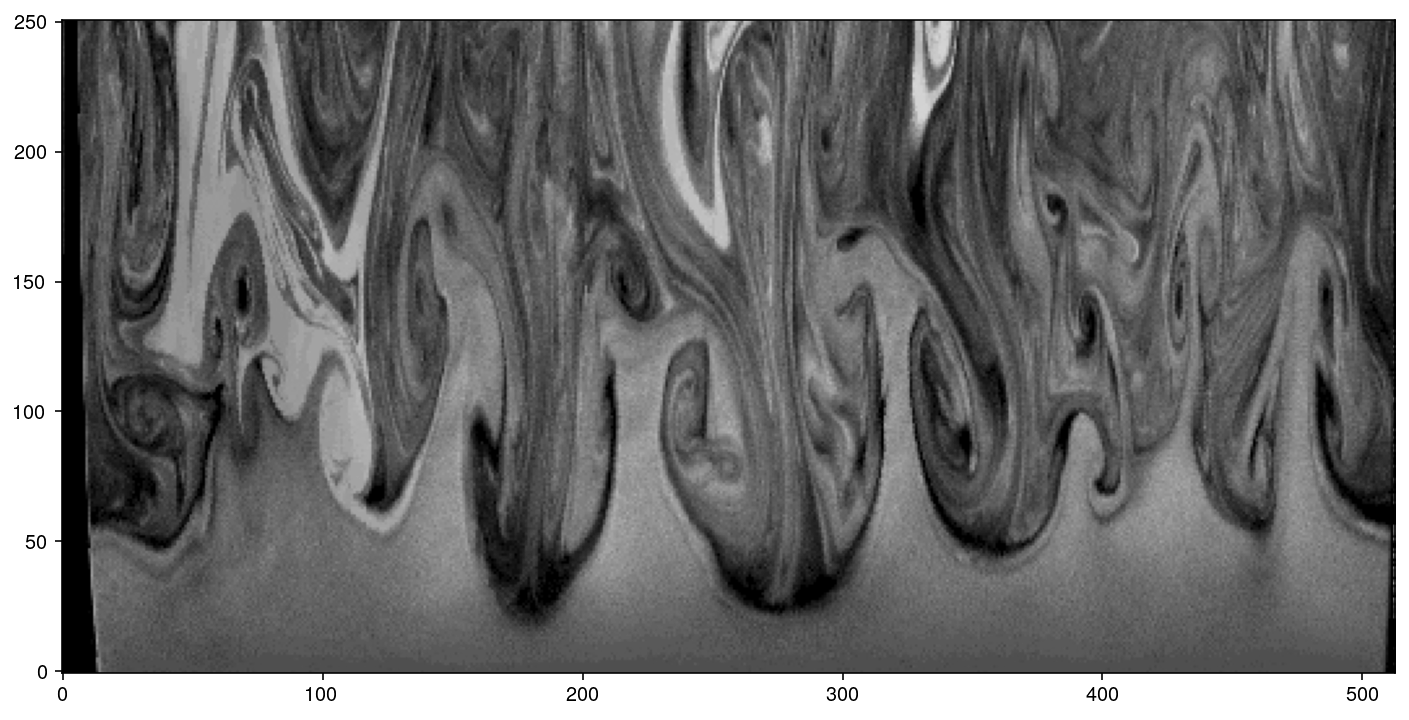

In [34]:
projectionZoneTourbi_fig,projectionZoneTourbi_ax=plt.subplots(1,1,figsize=[24,6])
ZTproj=projectionZoneTourbi_ax.imshow(grayvalueSplineInterp_ZT,cmap='gray',aspect='equal',origin='lower')
#projectionZoneTourbi_ax.axis('off')
#projectionZoneTourbi_ax.set_ylim(projectionZoneTourbi_ax.get_ylim()[::-1])

In [ ]:
del projectionZoneTourbi_fig,projectionZoneTourbi_ax

Il y a un glitch dans l'image. Zoomons.

In [ ]:
#grayvalueSplineInterp_ZT[30,:-1]

In [ ]:
projectionZoneTourbi_figbis,projectionZoneTourbi_axbis=plt.subplots(1,1,figsize=[12,4])
projectionZoneTourbi_axbis.imshow(grayvalueSplineInterp_ZT[:,-20:],cmap='gray',aspect='equal',origin='lower')

In [ ]:
del projectionZoneTourbi_figbis,projectionZoneTourbi_axbis

Pour enlever le glitch, et suivre l'hypothèse de périodicité, j'impose que seules les angleSplineInterp-1 colonnes de l'image portent de l'info et que image[:,interpKnotNumber]=image[:,0] (périodicité de 2$\pi$). On a alors:

In [ ]:
projectionZoneTourbi_figter,projectionZoneTourbi_axter=plt.subplots(1,1,figsize=[24,4])
projectionZoneTourbi_axter.imshow(grayvalueSplineInterp_ZT[:,:-1],cmap='gray',aspect='equal',origin='lower')
#projectionZoneTourbi_axter.set_xlim(0,20)

In [ ]:
del projectionZoneTourbi_figter,projectionZoneTourbi_axter

On crée une copie de l'image qui ne contient pas le glitch que l'on nomme <code>whirlZone_noGlitch</code>.

In [ ]:
whirlZone_noGlitch=dcopy(grayvalueSplineInterp_ZT[:,:-1])

Traitons tous les points correspondant à l'aiguille. Ils apparaissent comme le plateau constant à 0 sur le graphe ci-dessous, proches de l'origine.

In [ ]:
lineIntensity_fig,lineIntensity_ax=plt.subplots(1,1,figsize=[6,6])
lineIntensity_ax.plot(whirlZone_noGlitch[85,:-1],'bo-.')
#lineIntensity_ax.set_xlim(0,75)
#lineIntensity_ax[0].set_ylim(-40,20)
#lineIntensity_ax[1].plot(grayvalueSplineInterp_ZT_appended10[40,:-1],'bo-.')
#lineIntensity_ax[1].set_xlim(0,75)
#lineIntensity_ax[1].set_ylim(-40,20)

On cherche les indices de ces points (<code>np.argwhere</code>), on stocke ensuite les valeurs d'intensité pour le pixel situé deux pas avant le premier zéro ainsi que pour celui situé 2 pas après le dernier zéro. Sur cet intervalle de pas, on calcule la pente de l'intensité <code>grayvalueSplineInterp_ZT_15_needleInterpSlope</code>.

In [ ]:
whirlZone_noGlitch85=whirlZone_noGlitch[85,:]
whirlZone_noGlitch85_zerosIdx=np.argwhere(whirlZone_noGlitch85[0:40]==0)
whirlZone_noGlitch85_needleInterpVal1=whirlZone_noGlitch85[whirlZone_noGlitch85_zerosIdx[0]]
whirlZone_noGlitch85_needleInterpVal2=whirlZone_noGlitch85[whirlZone_noGlitch85_zerosIdx[-1]+2]
whirlZone_noGlitch85_needleInterpSlope=(whirlZone_noGlitch85_needleInterpVal2-whirlZone_noGlitch85_needleInterpVal1)/(whirlZone_noGlitch85_zerosIdx[-1]+2-(whirlZone_noGlitch85_zerosIdx[0]-2))
whirlZone_noGlitch85_needleInterpSlope

On définit ensuite la gamme d'indices <code>whirlZone_noGlitch85_needleInterpIdx</code> sur laquelle on veut interpoler l'intensité. On les calcule et on les stocke dans <code>whirlZone_noGlitch85_needleInterpValues</code>

In [ ]:
whirlZone_noGlitch85_needleInterpIdx=np.arange(whirlZone_noGlitch85_zerosIdx[0],whirlZone_noGlitch85_zerosIdx[-1]+3,1)
whirlZone_noGlitch85_needleInterpIdx

In [ ]:
whirlZone_noGlitch85_needleInterpValues=whirlZone_noGlitch85[whirlZone_noGlitch85_needleInterpIdx[0]]+whirlZone_noGlitch85_needleInterpSlope*(whirlZone_noGlitch85_needleInterpIdx-whirlZone_noGlitch85_needleInterpIdx[0])
whirlZone_noGlitch85_needleInterpValues

Pour tester le bon fonctionnement du code, on fait une copie profonde (<Code>dcopy</code>) de l'image initiale, dans laquelle on ira remplacer les pixels correspondant à l'aiguille par l'interpolation d'intensité.

In [ ]:
whirlZone_noGlitch85_copy=dcopy(whirlZone_noGlitch85)

In [ ]:
whirlZone_noGlitch85_copy[whirlZone_noGlitch85_needleInterpIdx]=whirlZone_noGlitch85_needleInterpValues.astype(int)

In [ ]:
lineIntensity_fig2,lineIntensity_ax2=plt.subplots(2,1,figsize=[12,5])
lineIntensity_ax2[0].plot(whirlZone_noGlitch85,'bo-.')
#lineIntensity_ax2[0].set_xlim(0,75)
#lineIntensity_ax[0].set_ylim(-40,20)
lineIntensity_ax2[1].plot(whirlZone_noGlitch85_copy,'bo-.')
#lineIntensity_ax2[1].set_xlim(0,75)
#lineIntensity_ax[1].set_ylim(-40,20)

On voit que ce code peut remplacer les pixels correspondant à l'aiguille par une interpolation linéaire de l'intensité de l'image entre les deux bords de l'aiguille.

Appliquons ce code à toutes les lignes de l'image.

In [ ]:
for i in range(0,grayvalueSplineInterp_ZT.shape[0]):
    #print(i)
    whirlZone_noGlitch_singleLine_zerosIdx=np.argwhere(whirlZone_noGlitch[i,0:40]==0)
    whirlZone_noGlitch_singleLine_needleInterpVal1=whirlZone_noGlitch[i,whirlZone_noGlitch_singleLine_zerosIdx[0]-2]
    whirlZone_noGlitch_singleLine_needleInterpVal2=whirlZone_noGlitch[i,whirlZone_noGlitch_singleLine_zerosIdx[-1]+2]
    whirlZone_noGlitch_singleLine_needleInterpSlope=(whirlZone_noGlitch_singleLine_needleInterpVal2-whirlZone_noGlitch_singleLine_needleInterpVal1)/(whirlZone_noGlitch_singleLine_zerosIdx[-1]+2-(whirlZone_noGlitch_singleLine_zerosIdx[0]-2))
    #grayvalueSplineInterp_ZT_line_needleInterpSlope
    whirlZone_noGlitch_singleLine_needleInterpIdx=np.arange(whirlZone_noGlitch_singleLine_zerosIdx[0]-2,whirlZone_noGlitch_singleLine_zerosIdx[-1]+3,1)
    whirlZone_noGlitch_singleLine_needleInterpValues=whirlZone_noGlitch[i,whirlZone_noGlitch_singleLine_needleInterpIdx[0]]+whirlZone_noGlitch_singleLine_needleInterpSlope*(whirlZone_noGlitch_singleLine_needleInterpIdx-whirlZone_noGlitch_singleLine_needleInterpIdx[0])
    whirlZone_noGlitch[i,whirlZone_noGlitch_singleLine_needleInterpIdx]=whirlZone_noGlitch_singleLine_needleInterpValues.astype(int)

In [ ]:
projectionZoneTourbi_fig2,projectionZoneTourbi_ax2=plt.subplots(1,1,figsize=[24,6])
ZTproj0=projectionZoneTourbi_ax2.imshow(whirlZone_noGlitch,cmap='gray',aspect='equal',origin='lower')


#### Création du stack d'image, calcul de l'intensité moyenne et stockage de cette image pour calculer le bruit de FFT/DCT

# Variations autour de la FFT

## FFT et DCT sur l'image brute

On va travailler sur quelques lignes de l'image sans aiguille que nous venons de créer. On va ajouter d'autres lignes à <code>whirlZone_noGlitch85</code>, une dans la zone de Marangoni, et une ailleurs dans zone tourbillonaire.

In [ ]:
whirlZone_noGlitch10=whirlZone_noGlitch[10,:]
whirlZone_noGlitch15=whirlZone_noGlitch[15,:]
whirlZone_noGlitch25=whirlZone_noGlitch[25,:]
whirlZone_noGlitch35=whirlZone_noGlitch[35,:]
whirlZone_noGlitch85=whirlZone_noGlitch[85,:]
whirlZone_noGlitch105=whirlZone_noGlitch[105,:]
whirlZone_noGlitch150=whirlZone_noGlitch[150,:]
whirlZone_noGlitch170=whirlZone_noGlitch[170,:]

Maintenant on va comparer leur FFT, sur les images brutes, sans traitement de symétrisation.

In [ ]:
whirlZone_noGlitch10_FFT=rfft(whirlZone_noGlitch10)
whirlZone_noGlitch15_FFT=rfft(whirlZone_noGlitch15)
whirlZone_noGlitch25_FFT=rfft(whirlZone_noGlitch25)
whirlZone_noGlitch35_FFT=rfft(whirlZone_noGlitch35)
whirlZone_noGlitch85_FFT=rfft(whirlZone_noGlitch85)
whirlZone_noGlitch105_FFT=rfft(whirlZone_noGlitch105)
whirlZone_noGlitch150_FFT=rfft(whirlZone_noGlitch150)
whirlZone_noGlitch170_FFT=rfft(whirlZone_noGlitch170)
whirlZone_noGlitchFFT_freq=rfftfreq(whirlZone_noGlitch.shape[1],angularScale)

On fait de même avec la DCT.

In [ ]:
whirlZone_noGlitch10_DCT=dct(whirlZone_noGlitch10)
whirlZone_noGlitch15_DCT=dct(whirlZone_noGlitch15)
whirlZone_noGlitch25_DCT=dct(whirlZone_noGlitch25)
whirlZone_noGlitch35_DCT=dct(whirlZone_noGlitch35)
whirlZone_noGlitch85_DCT=dct(whirlZone_noGlitch85)
whirlZone_noGlitch105_DCT=dct(whirlZone_noGlitch105)
whirlZone_noGlitch150_DCT=dct(whirlZone_noGlitch150)
whirlZone_noGlitch170_DCT=dct(whirlZone_noGlitch170)
whirlZone_noGlitchDCT_freq=np.array([i/(2*angularScale*whirlZone_noGlitch.shape[1]) for i in range(0,whirlZone_noGlitch.shape[1])])

On s'intéresse maintenant à l'amplitude des modes détectées par la FFT dans les trois régions.

In [ ]:
whirlZone_noGlitch10_FFT_Amp=np.abs(whirlZone_noGlitch10_FFT)**2
whirlZone_noGlitch15_FFT_Amp=np.abs(whirlZone_noGlitch15_FFT)**2
whirlZone_noGlitch25_FFT_Amp=np.abs(whirlZone_noGlitch25_FFT)**2
whirlZone_noGlitch35_FFT_Amp=np.abs(whirlZone_noGlitch35_FFT)**2
whirlZone_noGlitch85_FFT_Amp=np.abs(whirlZone_noGlitch85_FFT)**2
whirlZone_noGlitch105_FFT_Amp=np.abs(whirlZone_noGlitch105_FFT)**2
whirlZone_noGlitch150_FFT_Amp=np.abs(whirlZone_noGlitch150_FFT)**2
whirlZone_noGlitch170_FFT_Amp=np.abs(whirlZone_noGlitch170_FFT)**2

In [ ]:
whirlZone_noGlitch10_DCT_Amp=np.abs(whirlZone_noGlitch10_DCT)**2
whirlZone_noGlitch15_DCT_Amp=np.abs(whirlZone_noGlitch15_DCT)**2
whirlZone_noGlitch25_DCT_Amp=np.abs(whirlZone_noGlitch25_DCT)**2
whirlZone_noGlitch35_DCT_Amp=np.abs(whirlZone_noGlitch35_DCT)**2
whirlZone_noGlitch85_DCT_Amp=np.abs(whirlZone_noGlitch85_DCT)**2
whirlZone_noGlitch105_DCT_Amp=np.abs(whirlZone_noGlitch105_DCT)**2
whirlZone_noGlitch150_DCT_Amp=np.abs(whirlZone_noGlitch150_DCT)**2
whirlZone_noGlitch170_DCT_Amp=np.abs(whirlZone_noGlitch170_DCT)**2

#### FFT dans la zone de Marangoni
Traçons les amplitudes du bruit (lignes 10, 15, 25 et 35).

In [ ]:
noiseFFTAmp_Fig,noiseFFTAmp_Ax=plt.subplots(2,2,figsize=[12,12])
noiseFFTAmp_Ax[0,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch15_FFT_Amp[1:],label='ligne 15')
noiseFFTAmp_Ax[0,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch25_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 25')
noiseFFTAmp_Ax[0,0].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax[0,0].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax[0,0].set_yscale('log')
noiseFFTAmp_Ax[0,0].set_xlim(0,370)
noiseFFTAmp_Ax[0,0].set_ylim(1e3,1e8)
noiseFFTAmp_Ax[0,0].legend(loc='best')
#noiseFFTAmp_Ax[0,0].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseFFTAmp_Ax[0,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch25_FFT_Amp[1:],label='ligne 25')
noiseFFTAmp_Ax[0,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch35_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 35')
noiseFFTAmp_Ax[0,1].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax[0,1].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax[0,1].set_yscale('log')
noiseFFTAmp_Ax[0,1].set_xlim(0,370)
noiseFFTAmp_Ax[0,1].set_ylim(1e3,1e8)
noiseFFTAmp_Ax[0,1].legend(loc='best')
#noiseFFTAmp_Ax[0,1].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseFFTAmp_Ax[1,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch15_FFT_Amp[1:],label='ligne 15')
noiseFFTAmp_Ax[1,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch35_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 35')
noiseFFTAmp_Ax[1,0].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax[1,0].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax[1,0].set_yscale('log')
noiseFFTAmp_Ax[1,0].set_xlim(0,370)
noiseFFTAmp_Ax[1,0].set_ylim(1e3,1e8)
noiseFFTAmp_Ax[1,0].legend(loc='best')
#noiseFFTAmp_Fig.title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseFFTAmp_Ax[1,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch15_FFT_Amp[1:],label='ligne 15')
noiseFFTAmp_Ax[1,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch10_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 10')
noiseFFTAmp_Ax[1,1].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax[1,1].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax[1,1].set_yscale('log')
noiseFFTAmp_Ax[1,1].set_xlim(0,370)
noiseFFTAmp_Ax[1,1].set_ylim(1e3,1e8)
noiseFFTAmp_Ax[1,1].legend(loc='best')
#noiseFFTAmp_Fig.title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

On voit que les signaux sont similaires à grand angle, et diffèrent dans le bruit. Leurs amplitudes max sont de l'ordre de 10<sup>5</sup>.

#### DCT dans la zone de Marangoni
Traçons les amplitudes du bruit (lignes 10, 15, 25 et 35).

In [ ]:
noiseFFTAmp_Fig,noiseFFTAmp_Ax=plt.subplots(2,2,figsize=[12,12])
noiseFFTAmp_Ax[0,0].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch15_DCT_Amp[1:],label='ligne 15')
noiseFFTAmp_Ax[0,0].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch25_DCT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 25')
noiseFFTAmp_Ax[0,0].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax[0,0].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax[0,0].set_yscale('log')
noiseFFTAmp_Ax[0,0].set_xlim(0,370)
noiseFFTAmp_Ax[0,0].set_ylim(1e3,1e8)
noiseFFTAmp_Ax[0,0].legend(loc='best')
#noiseFFTAmp_Ax[0,0].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseFFTAmp_Ax[0,1].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch25_DCT_Amp[1:],label='ligne 25')
noiseFFTAmp_Ax[0,1].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch35_DCT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 35')
noiseFFTAmp_Ax[0,1].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax[0,1].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax[0,1].set_yscale('log')
noiseFFTAmp_Ax[0,1].set_xlim(0,370)
noiseFFTAmp_Ax[0,1].set_ylim(1e3,1e8)
noiseFFTAmp_Ax[0,1].legend(loc='best')
#noiseFFTAmp_Ax[0,1].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseFFTAmp_Ax[1,0].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch15_DCT_Amp[1:],label='ligne 15')
noiseFFTAmp_Ax[1,0].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch35_DCT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 35')
noiseFFTAmp_Ax[1,0].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax[1,0].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax[1,0].set_yscale('log')
noiseFFTAmp_Ax[1,0].set_xlim(0,370)
noiseFFTAmp_Ax[1,0].set_ylim(1e3,1e8)
noiseFFTAmp_Ax[1,0].legend(loc='best')
#noiseFFTAmp_Fig.title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseFFTAmp_Ax[1,1].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch15_DCT_Amp[1:],label='ligne 15')
noiseFFTAmp_Ax[1,1].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch10_DCT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 10')
noiseFFTAmp_Ax[1,1].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax[1,1].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax[1,1].set_yscale('log')
noiseFFTAmp_Ax[1,1].set_xlim(0,370)
noiseFFTAmp_Ax[1,1].set_ylim(1e3,1e8)
noiseFFTAmp_Ax[1,1].legend(loc='best')
#noiseFFTAmp_Fig.title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

#### FFT des signaux de la zone tourbillonaire
##### comparaison avec le bruit

In [ ]:
noiseSigFFTAmp_Fig,noiseSigFFTAmp_Ax=plt.subplots(2,3,figsize=[18,12])
noiseSigFFTAmp_Ax[0,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch15_FFT_Amp[1:],label='ligne 15')
noiseSigFFTAmp_Ax[0,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch85_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 85')
noiseSigFFTAmp_Ax[0,0].set_xlabel('Période angulaire (rad)')
noiseSigFFTAmp_Ax[0,0].set_ylabel('Amplitude (u. a.)')
noiseSigFFTAmp_Ax[0,0].set_yscale('log')
noiseSigFFTAmp_Ax[0,0].set_xlim(0,100)
noiseSigFFTAmp_Ax[0,0].set_ylim(1e3,1e8)
noiseSigFFTAmp_Ax[0,0].legend(loc='best')
#noiseFFTAmp_Ax[0,0].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseSigFFTAmp_Ax[0,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch15_FFT_Amp[1:],label='ligne 15')
noiseSigFFTAmp_Ax[0,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch105_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 105')
noiseSigFFTAmp_Ax[0,1].set_xlabel('Période angulaire (rad)')
noiseSigFFTAmp_Ax[0,1].set_ylabel('Amplitude (u. a.)')
noiseSigFFTAmp_Ax[0,1].set_yscale('log')
noiseSigFFTAmp_Ax[0,1].set_xlim(0,100)
noiseSigFFTAmp_Ax[0,1].set_ylim(1e3,1e8)
noiseSigFFTAmp_Ax[0,1].legend(loc='best')
#noiseFFTAmp_Ax[0,1].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseSigFFTAmp_Ax[0,2].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch15_FFT_Amp[1:],label='ligne 15')
noiseSigFFTAmp_Ax[0,2].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch150_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 150')
noiseSigFFTAmp_Ax[0,2].set_xlabel('Période angulaire (rad)')
noiseSigFFTAmp_Ax[0,2].set_ylabel('Amplitude (u. a.)')
noiseSigFFTAmp_Ax[0,2].set_yscale('log')
noiseSigFFTAmp_Ax[0,2].set_xlim(0,100)
noiseSigFFTAmp_Ax[0,2].set_ylim(1e3,1e8)
noiseSigFFTAmp_Ax[0,2].legend(loc='best')
#noiseFFTAmp_Fig.title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseSigFFTAmp_Ax[1,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch85_FFT_Amp[1:],label='ligne 85')
noiseSigFFTAmp_Ax[1,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch150_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 150')
noiseSigFFTAmp_Ax[1,0].set_xlabel('Période angulaire (rad)')
noiseSigFFTAmp_Ax[1,0].set_ylabel('Amplitude (u. a.)')
noiseSigFFTAmp_Ax[1,0].set_yscale('log')
noiseSigFFTAmp_Ax[1,0].set_xlim(0,100)
noiseSigFFTAmp_Ax[1,0].set_ylim(1e3,1e8)
noiseSigFFTAmp_Ax[1,0].legend(loc='best')
#noiseFFTAmp_Fig.title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseSigFFTAmp_Ax[1,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch150_FFT_Amp[1:],label='ligne 150')
noiseSigFFTAmp_Ax[1,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch170_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170')
noiseSigFFTAmp_Ax[1,1].set_xlabel('Période angulaire (rad)')
noiseSigFFTAmp_Ax[1,1].set_ylabel('Amplitude (u. a.)')
noiseSigFFTAmp_Ax[1,1].set_yscale('log')
noiseSigFFTAmp_Ax[1,1].set_xlim(0,100)
noiseSigFFTAmp_Ax[1,1].set_ylim(1e3,1e8)
noiseSigFFTAmp_Ax[1,1].legend(loc='best')

noiseSigFFTAmp_Ax[1,2].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch85_FFT_Amp[1:],label='ligne 85')
noiseSigFFTAmp_Ax[1,2].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch170_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170')
noiseSigFFTAmp_Ax[1,2].set_xlabel('Période angulaire (rad)')
noiseSigFFTAmp_Ax[1,2].set_ylabel('Amplitude (u. a.)')
noiseSigFFTAmp_Ax[1,2].set_yscale('log')
noiseSigFFTAmp_Ax[1,2].set_xlim(0,100)
noiseSigFFTAmp_Ax[1,2].set_ylim(1e3,1e8)
noiseSigFFTAmp_Ax[1,2].legend(loc='best')

Les signaux obtenus dans la région externe, a priori plutôt en dehors de la zone tourbillonaire, suggère un niveau de bruit aux alentours de 10<sup>6</sup>. Retraçons les figures ci-dessus avec ce niveau de bruit.

In [ ]:
noiseSigFFTAmp_Fig2,noiseSigFFTAmp_Ax2=plt.subplots(2,3,figsize=[18,12])
noiseSigFFTAmp_Ax2[0,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch15_FFT_Amp[1:],label='ligne 15')
noiseSigFFTAmp_Ax2[0,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch85_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 85')
noiseSigFFTAmp_Ax2[0,0].set_xlabel('Période angulaire (rad)')
noiseSigFFTAmp_Ax2[0,0].set_ylabel('Amplitude (u. a.)')
noiseSigFFTAmp_Ax2[0,0].set_yscale('log')
noiseSigFFTAmp_Ax2[0,0].set_xlim(0,100)
noiseSigFFTAmp_Ax2[0,0].set_ylim(1e6,1e8)
noiseSigFFTAmp_Ax2[0,0].legend(loc='best')
#noiseFFTAmp_Ax[0,0].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseSigFFTAmp_Ax2[0,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch15_FFT_Amp[1:],label='ligne 15')
noiseSigFFTAmp_Ax2[0,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch105_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 105')
noiseSigFFTAmp_Ax2[0,1].set_xlabel('Période angulaire (rad)')
noiseSigFFTAmp_Ax2[0,1].set_ylabel('Amplitude (u. a.)')
noiseSigFFTAmp_Ax2[0,1].set_yscale('log')
noiseSigFFTAmp_Ax2[0,1].set_xlim(0,100)
noiseSigFFTAmp_Ax2[0,1].set_ylim(1e6,1e8)
noiseSigFFTAmp_Ax2[0,1].legend(loc='best')
#noiseFFTAmp_Ax[0,1].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseSigFFTAmp_Ax2[0,2].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch15_FFT_Amp[1:],label='ligne 15')
noiseSigFFTAmp_Ax2[0,2].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch150_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 150')
noiseSigFFTAmp_Ax2[0,2].set_xlabel('Période angulaire (rad)')
noiseSigFFTAmp_Ax2[0,2].set_ylabel('Amplitude (u. a.)')
noiseSigFFTAmp_Ax2[0,2].set_yscale('log')
noiseSigFFTAmp_Ax2[0,2].set_xlim(0,100)
noiseSigFFTAmp_Ax2[0,2].set_ylim(1e6,1e8)
noiseSigFFTAmp_Ax2[0,2].legend(loc='best')
#noiseFFTAmp_Fig.title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseSigFFTAmp_Ax2[1,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch85_FFT_Amp[1:],label='ligne 85')
noiseSigFFTAmp_Ax2[1,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch150_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 150')
noiseSigFFTAmp_Ax2[1,0].set_xlabel('Période angulaire (rad)')
noiseSigFFTAmp_Ax2[1,0].set_ylabel('Amplitude (u. a.)')
noiseSigFFTAmp_Ax2[1,0].set_yscale('log')
noiseSigFFTAmp_Ax2[1,0].set_xlim(0,100)
noiseSigFFTAmp_Ax2[1,0].set_ylim(1e6,1e8)
noiseSigFFTAmp_Ax2[1,0].legend(loc='best')
#noiseFFTAmp_Fig.title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseSigFFTAmp_Ax2[1,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch150_FFT_Amp[1:],label='ligne 150')
noiseSigFFTAmp_Ax2[1,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch170_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170')
noiseSigFFTAmp_Ax2[1,1].set_xlabel('Période angulaire (rad)')
noiseSigFFTAmp_Ax2[1,1].set_ylabel('Amplitude (u. a.)')
noiseSigFFTAmp_Ax2[1,1].set_yscale('log')
noiseSigFFTAmp_Ax2[1,1].set_xlim(0,100)
noiseSigFFTAmp_Ax2[1,1].set_ylim(1e6,1e8)
noiseSigFFTAmp_Ax2[1,1].legend(loc='best')

noiseSigFFTAmp_Ax2[1,2].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch85_FFT_Amp[1:],label='ligne 85')
noiseSigFFTAmp_Ax2[1,2].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch170_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170')
noiseSigFFTAmp_Ax2[1,2].set_xlabel('Période angulaire (rad)')
noiseSigFFTAmp_Ax2[1,2].set_ylabel('Amplitude (u. a.)')
noiseSigFFTAmp_Ax2[1,2].set_yscale('log')
noiseSigFFTAmp_Ax2[1,2].set_xlim(0,100)
noiseSigFFTAmp_Ax2[1,2].set_ylim(1e6,1e8)
noiseSigFFTAmp_Ax2[1,2].legend(loc='best')

Traçons la DCT des mêmes graphes.

In [ ]:
noiseSigDCTAmp_Fig,noiseSigDCTAmp_Ax=plt.subplots(2,3,figsize=[18,12])
noiseSigDCTAmp_Ax[0,0].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch15_DCT_Amp[1:],label='ligne 15')
noiseSigDCTAmp_Ax[0,0].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch85_DCT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 85')
noiseSigDCTAmp_Ax[0,0].set_xlabel('Période angulaire (rad)')
noiseSigDCTAmp_Ax[0,0].set_ylabel('Amplitude (u. a.)')
noiseSigDCTAmp_Ax[0,0].set_yscale('log')
noiseSigDCTAmp_Ax[0,0].set_xlim(0,100)
noiseSigDCTAmp_Ax[0,0].set_ylim(1e3,1e8)
noiseSigDCTAmp_Ax[0,0].legend(loc='best')
#noiseFFTAmp_Ax[0,0].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseSigDCTAmp_Ax[0,1].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch15_DCT_Amp[1:],label='ligne 15')
noiseSigDCTAmp_Ax[0,1].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch105_DCT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 105')
noiseSigDCTAmp_Ax[0,1].set_xlabel('Période angulaire (rad)')
noiseSigDCTAmp_Ax[0,1].set_ylabel('Amplitude (u. a.)')
noiseSigDCTAmp_Ax[0,1].set_yscale('log')
noiseSigDCTAmp_Ax[0,1].set_xlim(0,100)
noiseSigDCTAmp_Ax[0,1].set_ylim(1e3,1e8)
noiseSigDCTAmp_Ax[0,1].legend(loc='best')
#noiseFFTAmp_Ax[0,1].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseSigDCTAmp_Ax[0,2].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch15_DCT_Amp[1:],label='ligne 15')
noiseSigDCTAmp_Ax[0,2].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch150_DCT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 150')
noiseSigDCTAmp_Ax[0,2].set_xlabel('Période angulaire (rad)')
noiseSigDCTAmp_Ax[0,2].set_ylabel('Amplitude (u. a.)')
noiseSigDCTAmp_Ax[0,2].set_yscale('log')
noiseSigDCTAmp_Ax[0,2].set_xlim(0,100)
noiseSigDCTAmp_Ax[0,2].set_ylim(1e3,1e8)
noiseSigDCTAmp_Ax[0,2].legend(loc='best')
#noiseFFDCmp_Fig.title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseSigDCTAmp_Ax[1,0].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch85_DCT_Amp[1:],label='ligne 85')
noiseSigDCTAmp_Ax[1,0].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch150_DCT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 150')
noiseSigDCTAmp_Ax[1,0].set_xlabel('Période angulaire (rad)')
noiseSigDCTAmp_Ax[1,0].set_ylabel('Amplitude (u. a.)')
noiseSigDCTAmp_Ax[1,0].set_yscale('log')
noiseSigDCTAmp_Ax[1,0].set_xlim(0,100)
noiseSigDCTAmp_Ax[1,0].set_ylim(1e3,1e8)
noiseSigDCTAmp_Ax[1,0].legend(loc='best')
#noiseFFTAmp_Fig.title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseSigDCTAmp_Ax[1,1].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch150_DCT_Amp[1:],label='ligne 150')
noiseSigDCTAmp_Ax[1,1].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch170_DCT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170')
noiseSigDCTAmp_Ax[1,1].set_xlabel('Période angulaire (rad)')
noiseSigDCTAmp_Ax[1,1].set_ylabel('Amplitude (u. a.)')
noiseSigDCTAmp_Ax[1,1].set_yscale('log')
noiseSigDCTAmp_Ax[1,1].set_xlim(0,100)
noiseSigDCTAmp_Ax[1,1].set_ylim(1e3,1e8)
noiseSigDCTAmp_Ax[1,1].legend(loc='best')

noiseSigDCTAmp_Ax[1,2].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch85_DCT_Amp[1:],label='ligne 85')
noiseSigDCTAmp_Ax[1,2].stem(180/(np.pi*whirlZone_noGlitchDCT_freq[1:]),whirlZone_noGlitch170_DCT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170')
noiseSigDCTAmp_Ax[1,2].set_xlabel('Période angulaire (rad)')
noiseSigDCTAmp_Ax[1,2].set_ylabel('Amplitude (u. a.)')
noiseSigDCTAmp_Ax[1,2].set_yscale('log')
noiseSigDCTAmp_Ax[1,2].set_xlim(0,100)
noiseSigDCTAmp_Ax[1,2].set_ylim(1e3,1e8)
noiseSigDCTAmp_Ax[1,2].legend(loc='best')

## Simple effet miroir

Utilisons maintenant la symétrisation de l'image. Dans le cas général, on colle 4 copies de l'image l'une à l'autre, et on renverse l'image le long de chaque joint. Ici on a besoin de renverser l'image seulement par basculement gauche droite. On réalise cela avec la fonction <code>np.fliplr</code>.

In [ ]:
whirlZone_noGlitch_flip=np.fliplr(whirlZone_noGlitch)
plt.imshow(whirlZone_noGlitch_flip,cmap='gray',aspect='equal',origin='lower')

In [ ]:
whirlZone_noGlitch_flipcat=np.concatenate((whirlZone_noGlitch,whirlZone_noGlitch_flip),axis=1)
plt.figure(figsize=[24,4])
plt.imshow(whirlZone_noGlitch_flipcat,cmap='gray',aspect='equal',origin='lower')
plt.plot([0,1024],[10, 10],'w--',lw=0.8)
plt.plot([0,1024],[15, 15],'w--',lw=0.8)
plt.plot([0,1024],[25, 25],'w--',lw=0.8)
plt.plot([0,1024],[35, 35],'w--',lw=0.8)
plt.plot([0,1024],[85, 85],'w--',lw=0.8)
plt.plot([0,1024],[105, 105],'w--',lw=0.8)
plt.plot([0,1024],[150, 150],'w--',lw=0.8)
plt.plot([0,1024],[170, 170],'w--',lw=0.8)
plt.plot([0,1024],[200, 200],'w--',lw=0.8)


### FFT de cette image miroir

On va comparer la FFT de cette image miroir avec celle de l'image brute.

In [ ]:
whirlZone_noGlitch_flipcat10=whirlZone_noGlitch_flipcat[10,:]
whirlZone_noGlitch_flipcat15=whirlZone_noGlitch_flipcat[15,:]
whirlZone_noGlitch_flipcat25=whirlZone_noGlitch_flipcat[25,:]
whirlZone_noGlitch_flipcat35=whirlZone_noGlitch_flipcat[35,:]
whirlZone_noGlitch_flipcat85=whirlZone_noGlitch_flipcat[85,:]
whirlZone_noGlitch_flipcat105=whirlZone_noGlitch_flipcat[105,:]
whirlZone_noGlitch_flipcat150=whirlZone_noGlitch_flipcat[150,:]
whirlZone_noGlitch_flipcat170=whirlZone_noGlitch_flipcat[170,:]
whirlZone_noGlitch_flipcat200=whirlZone_noGlitch_flipcat[200,:]

In [ ]:
whirlZone_noGlitch_flipcat10_FFT=rfft(whirlZone_noGlitch_flipcat10)
whirlZone_noGlitch_flipcat15_FFT=rfft(whirlZone_noGlitch_flipcat15)
whirlZone_noGlitch_flipcat25_FFT=rfft(whirlZone_noGlitch_flipcat25)
whirlZone_noGlitch_flipcat35_FFT=rfft(whirlZone_noGlitch_flipcat35)
whirlZone_noGlitch_flipcat85_FFT=rfft(whirlZone_noGlitch_flipcat85)
whirlZone_noGlitch_flipcat105_FFT=rfft(whirlZone_noGlitch_flipcat105)
whirlZone_noGlitch_flipcat150_FFT=rfft(whirlZone_noGlitch_flipcat150)
whirlZone_noGlitch_flipcat170_FFT=rfft(whirlZone_noGlitch_flipcat170)
whirlZone_noGlitch_flipcat200_FFT=rfft(whirlZone_noGlitch_flipcat200)
whirlZone_noGlitch_flipcatFFT_freq=rfftfreq(whirlZone_noGlitch_flipcat.shape[1],angularScale)

In [ ]:
whirlZone_noGlitch_flipcat10_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat10_FFT)**2
whirlZone_noGlitch_flipcat15_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat15_FFT)**2
whirlZone_noGlitch_flipcat25_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat25_FFT)**2
whirlZone_noGlitch_flipcat35_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat35_FFT)**2
whirlZone_noGlitch_flipcat85_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat85_FFT)**2
whirlZone_noGlitch_flipcat105_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat105_FFT)**2
whirlZone_noGlitch_flipcat150_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat150_FFT)**2
whirlZone_noGlitch_flipcat170_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat170_FFT)**2
whirlZone_noGlitch_flipcat200_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat200_FFT)**2

#### FFT dans la zone de Marangoni
Traçons les amplitudes du bruit (lignes 10, 15, 25 et 35).

In [ ]:
noiseFFTAmp_Fig3,noiseFFTAmp_Ax3=plt.subplots(2,2,figsize=[12,12])
noiseFFTAmp_Ax3[0,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch15_FFT_Amp[1:],label='ligne 15')
noiseFFTAmp_Ax3[0,1].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat15_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 15, miroir')
noiseFFTAmp_Ax3[0,1].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax3[0,1].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax3[0,1].set_yscale('log')
noiseFFTAmp_Ax3[0,1].set_xlim(0,370)
noiseFFTAmp_Ax3[0,1].set_ylim(1e3,1e8)
noiseFFTAmp_Ax3[0,1].legend(loc='best')
#noiseFFTAmp_Ax[0,0].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseFFTAmp_Ax3[1,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch25_FFT_Amp[1:],label='ligne 25')
noiseFFTAmp_Ax3[1,0].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat25_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 25, miroir')
noiseFFTAmp_Ax3[1,0].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax3[1,0].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax3[1,0].set_yscale('log')
noiseFFTAmp_Ax3[1,0].set_xlim(0,370)
noiseFFTAmp_Ax3[1,0].set_ylim(1e3,1e8)
noiseFFTAmp_Ax3[1,0].legend(loc='best')
#noiseFFTAmp_Ax[0,1].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseFFTAmp_Ax3[1,1].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch35_FFT_Amp[1:],label='ligne 35')
noiseFFTAmp_Ax3[1,1].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat35_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 35,miroir')
noiseFFTAmp_Ax3[1,1].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax3[1,1].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax3[1,1].set_yscale('log')
noiseFFTAmp_Ax3[1,1].set_xlim(0,370)
noiseFFTAmp_Ax3[1,1].set_ylim(1e3,1e8)
noiseFFTAmp_Ax3[1,1].legend(loc='best')
#noiseFFTAmp_Fig.title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseFFTAmp_Ax3[0,0].stem(180/(np.pi*whirlZone_noGlitchFFT_freq[1:]),whirlZone_noGlitch10_FFT_Amp[1:],label='ligne 10')
noiseFFTAmp_Ax3[0,0].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat10_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 10, miroir')
noiseFFTAmp_Ax3[0,0].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax3[0,0].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax3[0,0].set_yscale('log')
noiseFFTAmp_Ax3[0,0].set_xlim(0,370)
noiseFFTAmp_Ax3[0,0].set_ylim(1e3,1e8)
noiseFFTAmp_Ax3[0,0].legend(loc='best')
#noiseFFTAmp_Fig.title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

Le bruit a l'air plus consistant dans l'image miroir. il a une amplitude un peu plus grande.

### FFT des signaux de la zone tourbillonaire

In [ ]:
pmax4=100
AmpMax4=1e8
noiseFFTAmp_Fig4,noiseFFTAmp_Ax4=plt.subplots(2,3,figsize=[18,12])
noiseFFTAmp_Ax4[0,0].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat85_FFT_Amp[1:],label='ligne 85')
noiseFFTAmp_Ax4[0,0].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat105_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 105')
noiseFFTAmp_Ax4[0,0].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax4[0,0].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax4[0,0].set_yscale('log')
noiseFFTAmp_Ax4[0,0].set_xlim(0,pmax4)
noiseFFTAmp_Ax4[0,0].set_ylim(1e3,AmpMax4)
noiseFFTAmp_Ax4[0,0].legend(loc='best',frameon=False)

noiseFFTAmp_Ax4[0,1].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat85_FFT_Amp[1:],label='ligne 85, miroir')
noiseFFTAmp_Ax4[0,1].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat150_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 150, miroir')
noiseFFTAmp_Ax4[0,1].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax4[0,1].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax4[0,1].set_yscale('log')
noiseFFTAmp_Ax4[0,1].set_xlim(0,pmax4)
noiseFFTAmp_Ax4[0,1].set_ylim(1e3,AmpMax4)
noiseFFTAmp_Ax4[0,1].legend(loc='best',frameon=False)

noiseFFTAmp_Ax4[0,2].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat85_FFT_Amp[1:],label='ligne 85, miroir')
noiseFFTAmp_Ax4[0,2].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat170_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170, miroir')
noiseFFTAmp_Ax4[0,2].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax4[0,2].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax4[0,2].set_yscale('log')
noiseFFTAmp_Ax4[0,2].set_xlim(0,pmax4)
noiseFFTAmp_Ax4[0,2].set_ylim(1e3,AmpMax4)
noiseFFTAmp_Ax4[0,2].legend(loc='best',frameon=False)

noiseFFTAmp_Ax4[1,0].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat105_FFT_Amp[1:],label='ligne 105, miroir')
noiseFFTAmp_Ax4[1,0].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat150_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 150, miroir')
noiseFFTAmp_Ax4[1,0].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax4[1,0].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax4[1,0].set_yscale('log')
noiseFFTAmp_Ax4[1,0].set_xlim(0,pmax4)
noiseFFTAmp_Ax4[1,0].set_ylim(1e3,AmpMax4)
noiseFFTAmp_Ax4[1,0].legend(loc='best',frameon=False)
#noiseFFTAmp_Ax[0,1].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseFFTAmp_Ax4[1,1].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat105_FFT_Amp[1:],label='ligne 105,miroir')
noiseFFTAmp_Ax4[1,1].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat170_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170,miroir')
noiseFFTAmp_Ax4[1,1].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax4[1,1].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax4[1,1].set_yscale('log')
noiseFFTAmp_Ax4[1,1].set_xlim(0,pmax4)
noiseFFTAmp_Ax4[1,1].set_ylim(1e3,AmpMax4)
noiseFFTAmp_Ax4[1,1].legend(loc='best',frameon=False)

noiseFFTAmp_Ax4[1,2].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat200_FFT_Amp[1:],label='ligne 200,miroir')
noiseFFTAmp_Ax4[1,2].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat85_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 85,miroir')
noiseFFTAmp_Ax4[1,2].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax4[1,2].set_ylabel('Amplitude (u. a.)')
#noiseFFTAmp_Ax4[1,2].set_yscale('log')
noiseFFTAmp_Ax4[1,2].set_xlim(0,pmax4)
noiseFFTAmp_Ax4[1,2].set_ylim(1e3,AmpMax4)
noiseFFTAmp_Ax4[1,2].legend(loc='best',frameon=False)



Il y a un fond à 10<sup>7</sup> qui apparaît sur les signaux des lignes 150 et 170 qui correspondent à des zones où les tourbillons sont absents. Les signaux des lignes 85 et 105 montrent des pics par rapport aux fonds des images 150, 170 et ont des intensités de signaux des ordres de grandeur plus intenses que ce qui ressort de la zone de Marangoni.

### Effet du fenêtrage et de l'extension par zéros

Pour espérer encore améliorer le rapport signal sur bruit, je vais essayer d'appliquer un fenêtrage à l'image miroir dont la taille sera ensuite étendue à la puissance de 2 la plus grande possible en ajoutant des zéros.

Je vais d'abord soustraire 127 à toutes les intensités pour savoir où est mon zéro.

In [ ]:
whirlZone_noGlitch_flipcat_noMean=whirlZone_noGlitch_flipcat-127

In [ ]:
plt.figure(figsize=[24,6])
plt.imshow(whirlZone_noGlitch_flipcat_noMean,cmap='gray',origin='lower')

In [ ]:
plt.plot(whirlZone_noGlitch_flipcat_noMean[85,:])

Top! ça recentre le signal de façon plus raisonnable. Et en plus c'est basé sur le processus de calcul du stack originel.

Maintenant je vais fenêtrer le signal.

In [ ]:
whirlZone_noGlitch_flipcat_noMean[85,:].shape[0]

In [ ]:
triang_whirlZone_noGlitch_flipcat = triang(whirlZone_noGlitch_flipcat_noMean[85,:].shape[0])

In [ ]:
whirlZone_noGlitch_flipcat_noMean10=whirlZone_noGlitch_flipcat_noMean[10,:]
whirlZone_noGlitch_flipcat_noMean15=whirlZone_noGlitch_flipcat_noMean[15,:]
whirlZone_noGlitch_flipcat_noMean25=whirlZone_noGlitch_flipcat_noMean[25,:]
whirlZone_noGlitch_flipcat_noMean35=whirlZone_noGlitch_flipcat_noMean[35,:]
whirlZone_noGlitch_flipcat_noMean85=whirlZone_noGlitch_flipcat_noMean[85,:]
whirlZone_noGlitch_flipcat_noMean105=whirlZone_noGlitch_flipcat_noMean[105,:]
whirlZone_noGlitch_flipcat_noMean150=whirlZone_noGlitch_flipcat_noMean[150,:]
whirlZone_noGlitch_flipcat_noMean170=whirlZone_noGlitch_flipcat_noMean[170,:]
whirlZone_noGlitch_flipcat_noMean200=whirlZone_noGlitch_flipcat_noMean[200,:]

In [ ]:
whirlZone_noGlitch_flipcat_noMean10_windowed=whirlZone_noGlitch_flipcat_noMean10*triang_whirlZone_noGlitch_flipcat
whirlZone_noGlitch_flipcat_noMean15_windowed=whirlZone_noGlitch_flipcat_noMean15*triang_whirlZone_noGlitch_flipcat
whirlZone_noGlitch_flipcat_noMean25_windowed=whirlZone_noGlitch_flipcat_noMean25*triang_whirlZone_noGlitch_flipcat
whirlZone_noGlitch_flipcat_noMean35_windowed=whirlZone_noGlitch_flipcat_noMean35*triang_whirlZone_noGlitch_flipcat
whirlZone_noGlitch_flipcat_noMean85_windowed=whirlZone_noGlitch_flipcat_noMean85*triang_whirlZone_noGlitch_flipcat
whirlZone_noGlitch_flipcat_noMean105_windowed=whirlZone_noGlitch_flipcat_noMean105*triang_whirlZone_noGlitch_flipcat
whirlZone_noGlitch_flipcat_noMean150_windowed=whirlZone_noGlitch_flipcat_noMean150*triang_whirlZone_noGlitch_flipcat
whirlZone_noGlitch_flipcat_noMean170_windowed=whirlZone_noGlitch_flipcat_noMean170*triang_whirlZone_noGlitch_flipcat
whirlZone_noGlitch_flipcat_noMean200_windowed=whirlZone_noGlitch_flipcat_noMean200*triang_whirlZone_noGlitch_flipcat

In [ ]:
plt.plot(whirlZone_noGlitch_flipcat_noMean85_windowed)

Calculons la FFT de ce signal et comparos au signal non-fenêtré.

In [ ]:
whirlZone_noGlitch_flipcat_noMean10_windowed_FFT=rfft(whirlZone_noGlitch_flipcat_noMean10_windowed)
whirlZone_noGlitch_flipcat_noMean15_windowed_FFT=rfft(whirlZone_noGlitch_flipcat_noMean15_windowed)
whirlZone_noGlitch_flipcat_noMean25_windowed_FFT=rfft(whirlZone_noGlitch_flipcat_noMean25_windowed)
whirlZone_noGlitch_flipcat_noMean35_windowed_FFT=rfft(whirlZone_noGlitch_flipcat_noMean35_windowed)
whirlZone_noGlitch_flipcat_noMean85_windowed_FFT=rfft(whirlZone_noGlitch_flipcat_noMean85_windowed)
whirlZone_noGlitch_flipcat_noMean105_windowed_FFT=rfft(whirlZone_noGlitch_flipcat_noMean105_windowed)
whirlZone_noGlitch_flipcat_noMean150_windowed_FFT=rfft(whirlZone_noGlitch_flipcat_noMean150_windowed)
whirlZone_noGlitch_flipcat_noMean170_windowed_FFT=rfft(whirlZone_noGlitch_flipcat_noMean170_windowed)
whirlZone_noGlitch_flipcat_noMean200_windowed_FFT=rfft(whirlZone_noGlitch_flipcat_noMean200_windowed)
whirlZone_noGlitch_flipcat_noMean170_windowedFFT_freq=rfftfreq(whirlZone_noGlitch_flipcat_noMean170_windowed.shape[0],angularScale)

In [ ]:
whirlZone_noGlitch_flipcat_noMean10_windowed_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean10_windowed_FFT)**2
whirlZone_noGlitch_flipcat_noMean15_windowed_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean15_windowed_FFT)**2
whirlZone_noGlitch_flipcat_noMean25_windowed_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean25_windowed_FFT)**2
whirlZone_noGlitch_flipcat_noMean35_windowed_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean35_windowed_FFT)**2
whirlZone_noGlitch_flipcat_noMean85_windowed_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean85_windowed_FFT)**2
whirlZone_noGlitch_flipcat_noMean105_windowed_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean105_windowed_FFT)**2
whirlZone_noGlitch_flipcat_noMean150_windowed_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean150_windowed_FFT)**2
whirlZone_noGlitch_flipcat_noMean170_windowed_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean170_windowed_FFT)**2
whirlZone_noGlitch_flipcat_noMean200_windowed_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean200_windowed_FFT)**2

In [ ]:
pmax5=100
noiseFFTAmp_Fig5,noiseFFTAmp_Ax5=plt.subplots(2,3,figsize=[18,12])
noiseFFTAmp_Ax5[0,0].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean85_windowed_FFT_Amp[1:],label='ligne 85, fenêtré')
noiseFFTAmp_Ax5[0,0].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean105_windowed_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 105, fenêtré')
noiseFFTAmp_Ax5[0,0].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax5[0,0].set_ylabel('Amplitude (u. a.)')
#noiseFFTAmp_Ax5[0,0].set_yscale('log')
noiseFFTAmp_Ax5[0,0].set_xlim(0,pmax5)
noiseFFTAmp_Ax5[0,0].set_ylim(1e3,5e7)
noiseFFTAmp_Ax5[0,0].legend(loc='best',frameon=False)

noiseFFTAmp_Ax5[0,1].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean85_windowed_FFT_Amp[1:],label='ligne 85, fenêtré')
noiseFFTAmp_Ax5[0,1].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean150_windowed_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 150, fenêtré')
noiseFFTAmp_Ax5[0,1].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax5[0,1].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax5[0,1].set_yscale('log')
noiseFFTAmp_Ax5[0,1].set_xlim(0,pmax5)
noiseFFTAmp_Ax5[0,1].set_ylim(1e3,1e8)
noiseFFTAmp_Ax5[0,1].legend(loc='best',frameon=False)

noiseFFTAmp_Ax5[0,2].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean85_windowed_FFT_Amp[1:],label='ligne 85, fenêtré')
noiseFFTAmp_Ax5[0,2].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean200_windowed_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 200, fenêtré')
noiseFFTAmp_Ax5[0,2].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax5[0,2].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax5[0,2].set_yscale('log')
noiseFFTAmp_Ax5[0,2].set_xlim(0,pmax5)
noiseFFTAmp_Ax5[0,2].set_ylim(1e3,1e8)
noiseFFTAmp_Ax5[0,2].legend(loc='best',frameon=False)

noiseFFTAmp_Ax5[1,0].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean105_windowed_FFT_Amp[1:],label='ligne 105, fenêtré')
noiseFFTAmp_Ax5[1,0].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean150_windowed_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 150, fenêtré')
noiseFFTAmp_Ax5[1,0].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax5[1,0].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax5[1,0].set_yscale('log')
noiseFFTAmp_Ax5[1,0].set_xlim(0,pmax5)
noiseFFTAmp_Ax5[1,0].set_ylim(1e3,1e8)
noiseFFTAmp_Ax5[1,0].legend(loc='best',frameon=False)
#noiseFFTAmp_Ax[0,1].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseFFTAmp_Ax5[1,1].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean105_windowed_FFT_Amp[1:],label='ligne 105, fenêtré')
noiseFFTAmp_Ax5[1,1].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean170_windowed_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170, fenêtré')
noiseFFTAmp_Ax5[1,1].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax5[1,1].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax5[1,1].set_yscale('log')
noiseFFTAmp_Ax5[1,1].set_xlim(0,pmax5)
noiseFFTAmp_Ax5[1,1].set_ylim(1e3,1e8)
noiseFFTAmp_Ax5[1,1].legend(loc='best',frameon=False)

noiseFFTAmp_Ax5[1,2].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean150_windowed_FFT_Amp[1:],label='ligne 150, fenêtré')
noiseFFTAmp_Ax5[1,2].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean170_windowed_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170, fenêtré')
noiseFFTAmp_Ax5[1,2].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax5[1,2].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax5[1,2].set_yscale('log')
noiseFFTAmp_Ax5[1,2].set_xlim(0,pmax5)
noiseFFTAmp_Ax5[1,2].set_ylim(1e3,1e8)
noiseFFTAmp_Ax5[1,2].legend(loc='best',frameon=False)

Ajoutons un zero-padding.

In [ ]:
padding_width=2**14
padding_width

In [ ]:
whirlZone_noGlitch_flipcat_noMean10_windowed_padded=np.pad(whirlZone_noGlitch_flipcat_noMean10_windowed,padding_width,'constant')
whirlZone_noGlitch_flipcat_noMean15_windowed_padded=np.pad(whirlZone_noGlitch_flipcat_noMean15_windowed,padding_width,'constant')
whirlZone_noGlitch_flipcat_noMean25_windowed_padded=np.pad(whirlZone_noGlitch_flipcat_noMean25_windowed,padding_width,'constant')
whirlZone_noGlitch_flipcat_noMean35_windowed_padded=np.pad(whirlZone_noGlitch_flipcat_noMean35_windowed,padding_width,'constant')
whirlZone_noGlitch_flipcat_noMean85_windowed_padded=np.pad(whirlZone_noGlitch_flipcat_noMean85_windowed,padding_width,'constant')
whirlZone_noGlitch_flipcat_noMean105_windowed_padded=np.pad(whirlZone_noGlitch_flipcat_noMean105_windowed,padding_width,'constant')
whirlZone_noGlitch_flipcat_noMean150_windowed_padded=np.pad(whirlZone_noGlitch_flipcat_noMean150_windowed,padding_width,'constant')
whirlZone_noGlitch_flipcat_noMean170_windowed_padded=np.pad(whirlZone_noGlitch_flipcat_noMean170_windowed,padding_width,'constant')

In [ ]:
whirlZone_noGlitch_flipcat_noMean10_windowed_padded_FFT=rfft(whirlZone_noGlitch_flipcat_noMean10_windowed_padded)
whirlZone_noGlitch_flipcat_noMean15_windowed_padded_FFT=rfft(whirlZone_noGlitch_flipcat_noMean15_windowed_padded)
whirlZone_noGlitch_flipcat_noMean25_windowed_padded_FFT=rfft(whirlZone_noGlitch_flipcat_noMean25_windowed_padded)
whirlZone_noGlitch_flipcat_noMean35_windowed_padded_FFT=rfft(whirlZone_noGlitch_flipcat_noMean35_windowed_padded)
whirlZone_noGlitch_flipcat_noMean85_windowed_padded_FFT=rfft(whirlZone_noGlitch_flipcat_noMean85_windowed_padded)
whirlZone_noGlitch_flipcat_noMean105_windowed_padded_FFT=rfft(whirlZone_noGlitch_flipcat_noMean105_windowed_padded)
whirlZone_noGlitch_flipcat_noMean150_windowed_padded_FFT=rfft(whirlZone_noGlitch_flipcat_noMean150_windowed_padded)
whirlZone_noGlitch_flipcat_noMean170_windowed_padded_FFT=rfft(whirlZone_noGlitch_flipcat_noMean170_windowed_padded)
whirlZone_noGlitch_flipcat_noMean170_windowed_paddedFFT_freq=rfftfreq(whirlZone_noGlitch_flipcat_noMean170_windowed_padded.shape[0],angularScale)

In [ ]:
whirlZone_noGlitch_flipcat_noMean10_windowed_padded_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean10_windowed_padded_FFT)**2
whirlZone_noGlitch_flipcat_noMean15_windowed_padded_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean15_windowed_padded_FFT)**2
whirlZone_noGlitch_flipcat_noMean25_windowed_padded_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean25_windowed_padded_FFT)**2
whirlZone_noGlitch_flipcat_noMean35_windowed_padded_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean35_windowed_padded_FFT)**2
whirlZone_noGlitch_flipcat_noMean85_windowed_padded_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean85_windowed_padded_FFT)**2
whirlZone_noGlitch_flipcat_noMean105_windowed_padded_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean105_windowed_padded_FFT)**2
whirlZone_noGlitch_flipcat_noMean150_windowed_padded_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean150_windowed_padded_FFT)**2
whirlZone_noGlitch_flipcat_noMean170_windowed_padded_FFT_Amp=np.abs(whirlZone_noGlitch_flipcat_noMean170_windowed_padded_FFT)**2

In [ ]:
pmax5=100
noiseFFTAmp_Fig6,noiseFFTAmp_Ax6=plt.subplots(2,3,figsize=[18,12])
noiseFFTAmp_Ax6[0,0].stem(180/(np.pi*whirlZone_noGlitch_flipcat_noMean170_windowed_paddedFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean85_windowed_padded_FFT_Amp[1:],label='ligne 85, fenêtré paddé')
noiseFFTAmp_Ax6[0,0].stem(180/(np.pi*whirlZone_noGlitch_flipcat_noMean170_windowed_paddedFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean105_windowed_padded_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 105, fenêtré paddé')
noiseFFTAmp_Ax6[0,0].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax6[0,0].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax6[0,0].set_yscale('log')
noiseFFTAmp_Ax6[0,0].set_xlim(0,pmax5)
noiseFFTAmp_Ax6[0,0].set_ylim(1e3,1e8)
noiseFFTAmp_Ax6[0,0].legend(loc='best',frameon=False)

noiseFFTAmp_Ax6[0,1].stem(180/(np.pi*whirlZone_noGlitch_flipcat_noMean170_windowed_paddedFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean85_windowed_padded_FFT_Amp[1:],label='ligne 85, fenêtré')
noiseFFTAmp_Ax6[0,1].stem(180/(np.pi*whirlZone_noGlitch_flipcat_noMean170_windowed_paddedFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean150_windowed_padded_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 150, fenêtré paddé')
noiseFFTAmp_Ax6[0,1].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax6[0,1].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax6[0,1].set_yscale('log')
noiseFFTAmp_Ax6[0,1].set_xlim(0,pmax5)
noiseFFTAmp_Ax6[0,1].set_ylim(1e3,1e8)
noiseFFTAmp_Ax6[0,1].legend(loc='best',frameon=False)

noiseFFTAmp_Ax6[0,2].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean85_windowed_FFT_Amp[1:],label='ligne 85, fenêtré')
noiseFFTAmp_Ax6[0,2].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean170_windowed_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170, fenêtré')
noiseFFTAmp_Ax6[0,2].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax6[0,2].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax6[0,2].set_yscale('log')
noiseFFTAmp_Ax6[0,2].set_xlim(0,pmax5)
noiseFFTAmp_Ax6[0,2].set_ylim(1e3,1e8)
noiseFFTAmp_Ax6[0,2].legend(loc='best',frameon=False)

noiseFFTAmp_Ax6[1,0].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean105_windowed_FFT_Amp[1:],label='ligne 105, fenêtré')
noiseFFTAmp_Ax6[1,0].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean150_windowed_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 150, fenêtré')
noiseFFTAmp_Ax6[1,0].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax6[1,0].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax6[1,0].set_yscale('log')
noiseFFTAmp_Ax6[1,0].set_xlim(0,pmax5)
noiseFFTAmp_Ax6[1,0].set_ylim(1e3,1e8)
noiseFFTAmp_Ax6[1,0].legend(loc='best',frameon=False)
#noiseFFTAmp_A6[0,1].set_title('Comparaison des FFT de deux lignes sorties de la zone Marangoni.')

noiseFFTAmp_Ax6[1,1].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean105_windowed_FFT_Amp[1:],label='ligne 105, fenêtré')
noiseFFTAmp_Ax6[1,1].stem(180/(np.pi*whirlZone_noGlitch_flipcatFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean170_windowed_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170, fenêtré')
noiseFFTAmp_Ax6[1,1].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax6[1,1].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax6[1,1].set_yscale('log')
noiseFFTAmp_Ax6[1,1].set_xlim(0,pmax5)
noiseFFTAmp_Ax6[1,1].set_ylim(1e3,1e8)
noiseFFTAmp_Ax6[1,1].legend(loc='best',frameon=False)

noiseFFTAmp_Ax6[1,2].stem(180/(np.pi*whirlZone_noGlitch_flipcat_noMean170_windowed_paddedFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean150_windowed_padded_FFT_Amp[1:],label='ligne 150, fenêtré')
noiseFFTAmp_Ax6[1,2].stem(180/(np.pi*whirlZone_noGlitch_flipcat_noMean170_windowed_paddedFFT_freq[1:]),whirlZone_noGlitch_flipcat_noMean170_windowed_padded_FFT_Amp[1:],linefmt='r-.',markerfmt='ro',label='ligne 170, fenêtré')
noiseFFTAmp_Ax6[1,2].set_xlabel('Période angulaire (rad)')
noiseFFTAmp_Ax6[1,2].set_ylabel('Amplitude (u. a.)')
noiseFFTAmp_Ax6[1,2].set_yscale('log')
noiseFFTAmp_Ax6[1,2].set_xlim(0,pmax5)
noiseFFTAmp_Ax6[1,2].set_ylim(1e3,1e8)
noiseFFTAmp_Ax6[1,2].legend(loc='best',frameon=False)

### Amélioration avec un tiling de 10 voire 100 copies?

In [ ]:
grayvalueSplineInterp_ZT_appended10=np.tile(grayvalueSplineInterp_ZT_flipcat,10)
grayvalueSplineInterp_ZT_appended10.shape

In [ ]:
grayvalueSplineInterp_ZT_appended100=np.tile(grayvalueSplineInterp_ZT_flipcat,100)
grayvalueSplineInterp_ZT_appended100.shape

In [ ]:
projectionZoneTourbi_figquarto,projectionZoneTourbi_axquarto=plt.subplots(1,1,figsize=[30,2])
extendedProjected_WhirlZone=projectionZoneTourbi_axquarto.imshow(grayvalueSplineInterp_ZT_appended10,cmap='gray',aspect='equal',origin='lower')
plt.xlim(1000,1100)

In [ ]:
del projectionZoneTourbi_figquarto,projectionZoneTourbi_axquarto

In [ ]:
grayvalueSplineInterp_ZT_mean=np.mean(grayvalueSplineInterp_ZT_flipcat)
grayvalueSplineInterp_ZT_unMeaned=grayvalueSplineInterp_ZT_flipcat-grayvalueSplineInterp_ZT_mean

In [ ]:
grayvalueSplineInterp_ZT_appended10=np.tile(grayvalueSplineInterp_ZT_unMeaned[:,:-1],10)
grayvalueSplineInterp_ZT_appended10.shape

In [ ]:
grayvalueSplineInterp_ZT_appended100=np.tile(grayvalueSplineInterp_ZT_unMeaned[:,:-1],100)
grayvalueSplineInterp_ZT_appended100.shape

### Application à la ligne 15 de l'image

In [ ]:
grayvalueSplineInterp_ZT_interp_unMeaned=dcopy(grayvalueSplineInterp_ZT_unMeaned[15,:-1])
grayvalueSplineInterp_ZT_interp_unMeaned_append10=dcopy(grayvalueSplineInterp_ZT_appended10[15,:-1])
grayvalueSplineInterp_ZT_interp_unMeaned_append100=dcopy(grayvalueSplineInterp_ZT_appended100[15,:-1])

In [ ]:
hanning_unMeaned = triang(grayvalueSplineInterp_ZT_interp_unMeaned.shape[0])
hanning_unMeaned.shape

In [ ]:
hanning_unMeaned_append10 = triang(grayvalueSplineInterp_ZT_interp_unMeaned_append10.shape[0])
hanning_unMeaned_append10.shape

In [ ]:
hanning_unMeaned_append100 = triang(grayvalueSplineInterp_ZT_interp_unMeaned_append100.shape[0])
hanning_unMeaned_append100.shape

In [ ]:
fftTest_unMeaned=rfft(grayvalueSplineInterp_ZT_interp_unMeaned*hanning_unMeaned)
fftTest_freq_unMeaned=rfftfreq(grayvalueSplineInterp_ZT_interp_unMeaned.shape[0],angularScale)

In [ ]:
fftTest_unMeaned_append10=rfft(grayvalueSplineInterp_ZT_interp_unMeaned_append10*hanning_unMeaned_append10)
#fftTest_unMeaned_append10=rfft(grayvalueSplineInterp_ZT_interp_unMeaned_append10)
fftTest_freq_unMeaned_append10=rfftfreq(grayvalueSplineInterp_ZT_interp_unMeaned_append10[:-1].shape[0],angularScale)

In [ ]:
fftTest_unMeaned_append100=rfft(grayvalueSplineInterp_ZT_interp_unMeaned_append100*hanning_unMeaned_append100)
#fftTest_unMeaned_append10=rfft(grayvalueSplineInterp_ZT_interp_unMeaned_append10)
fftTest_freq_unMeaned_append100=rfftfreq(grayvalueSplineInterp_ZT_interp_unMeaned_append100[:-1].shape[0],angularScale)

In [ ]:
dctTest_unMeaned=dct(grayvalueSplineInterp_ZT_interp_unMeaned)
dctTest_freq_unMeaned=np.array([i/(2*angularScale*grayvalueSplineInterp_ZT_interp_unMeaned[:-1].shape[0]) for i in range(0,grayvalueSplineInterp_ZT_interp_unMeaned[:-1].shape[0])])
#1/(np.pi*dctTest_freq_unMeaned)

In [ ]:
dctTest_unMeaned_append10=dct(grayvalueSplineInterp_ZT_interp_unMeaned_append10)
dctTest_freq_unMeaned_append10=np.array([i/(2*angularScale*grayvalueSplineInterp_ZT_interp_unMeaned_append10[:-1].shape[0]) for i in range(0,grayvalueSplineInterp_ZT_interp_unMeaned_append10[:-1].shape[0])])
#1/(np.pi*dctTest_freq_unMeaned)

In [ ]:
dctTest_unMeaned_append100=dct(grayvalueSplineInterp_ZT_interp_unMeaned_append100)
dctTest_freq_unMeaned_append100=np.array([i/(2*angularScale*grayvalueSplineInterp_ZT_interp_unMeaned_append100[:-1].shape[0]) for i in range(0,grayvalueSplineInterp_ZT_interp_unMeaned_append10[:-1].shape[0])])
#1/(np.pi*dctTest_freq_unMeaned)

In [ ]:
plt.figure(figsize=[8,8])
plt.stem(180/(np.pi*fftTest_freq_unMeaned[1:]),10*np.log((np.abs(fftTest_unMeaned[1:])**2/np.max(np.abs(np.abs(fftTest_unMeaned[1:])**2)))),bottom=-250)
#plt.stem(np.pi*dctTest_freq_unMeaned[1:],np.abs(dctTest_unMeaned[1:])**2,linefmt='r-.',markerfmt='ro')
#plt.yscale('log')
plt.xlim(0,90)
plt.xlabel('Angle period (degrees)')
plt.ylim(-30,10)
plt.ylabel('FFT amplitude (dB)')
plt.title('FFT Amplitude of the raw unMeaned mirrored image')

In [ ]:
plt.figure(figsize=[8,8])
plt.stem(180/(np.pi*fftTest_freq_unMeaned_append10[1:]),10*np.log(np.abs(fftTest_unMeaned_append10[1:])**2/np.max(np.abs(fftTest_unMeaned_append10[1:])**2)),bottom=-250)
#plt.stem(1/dctTest_freq_unMeaned_append10[1:],10*np.log(np.abs(dctTest_unMeaned_append10[1:])**2),linefmt='r-.',markerfmt='ro')
#plt.yscale('log')
plt.xlim(0,90)
plt.xlabel('Angle period (degrees)')
plt.ylim(-30,10)
plt.xlabel('FFT amplitude (dB)')
plt.title('FFT Amplitude of the raw unMeaned mirrored image, tiled 10 times')

In [ ]:
iDx_fft2=np.argmax(np.abs(fftTest_unMeaned_append10[1:]))
print(iDx_fft2)
1/(np.pi*fftTest_freq_unMeaned_append10[iDx_fft2+1])*180

In [ ]:
plt.figure(figsize=[8,8])
plt.stem(180/(np.pi*fftTest_freq_unMeaned_append100[1:]),10*np.log(np.abs(fftTest_unMeaned_append100[1:])**2/np.max(np.abs(fftTest_unMeaned_append100[1:])**2)),bottom=-250)
#plt.stem(np.abs(fftTest_unMeaned_append100[1:])**2,bottom=-250)

#plt.stem(1/dctTest_freq_unMeaned_append10[1:],10*np.log(np.abs(dctTest_unMeaned_append10[1:])**2),linefmt='r-.',markerfmt='ro')
#plt.yscale('log')
plt.xlim(0,90)
plt.ylim(-30,10)
plt.xlabel('Angle period (degrees)')
plt.ylabel('FFT amplitude (dB)')
plt.title('FFT Amplitude of the raw unMeaned mirrored image, tiled 100 times')

In [ ]:
iDx_fft3=np.argmax(np.abs(fftTest_unMeaned_append100[1:]))
print(iDx_fft3)
1/(np.pi*fftTest_freq_unMeaned_append100[iDx_fft3+1])*180

In [ ]:
5.5*1/(np.pi*fftTest_freq_unMeaned_append100[iDx_fft3+1])*180

Ce signal est encourageant, car la période associée n'est pas une fraction de trivial de $\pi$ *a priori* (bon, en fait c'est $11\pi/2$)

In [ ]:
pixDomain=np.arange(0,2*np.pi,4*np.pi/(grayvalueSplineInterp_ZT_interp_unMeaned.shape[0]+1))
#print(pixDomain)
print(pixDomain.shape)

In [ ]:
mode_Signal=40*np.sin(2*np.pi*pixDomain/fftTest_freq_unMeaned_append100[iDx_fft3+1]*358/360)
mode_Signal.shape

In [ ]:
plt.plot(pixDomain,grayvalueSplineInterp_ZT_interp_unMeaned[:512])
plt.plot(pixDomain,mode_Signal,'y--')
plt.xlim(0,6.28)

Essayons de voir si j'améliore l'accord en prenant les 5 pics que je vois se dégager de la FFT.

In [ ]:
fft3_append100_peaksIdx=find_peaks(np.abs(fftTest_unMeaned_append100[1:1200])**2,threshold=0.5e11)
fft3_append100_peaksIdx[0]

In [ ]:
allModes_fft3=fftTest_freq_unMeaned_append10[fft3_append100_peaksIdx[0]+1]
allModes_fft3

#### Sur l'image, que donne la FFT en chaque ligne?
Appliquons l'algo correspondant à la centaine de duplicata à l'image entière.

In [ ]:
#print(grayvalueSplineInterp_ZT_appended100.shape)
triang_unMeaned_append100 = triang(grayvalueSplineInterp_ZT_appended100.shape[1])
#print(triang_unMeaned_append100.shape)
fftTest_unMeaned_append100_line=np.zeros((1,grayvalueSplineInterp_ZT_appended100.shape[1]//2),dtype=np.complex_)
#print(fftTest_unMeaned_append100_line.shape)
fftTest_unMeaned_append100_image_Amp=np.zeros((grayvalueSplineInterp_ZT_appended100.shape[0],grayvalueSplineInterp_ZT_appended100.shape[1]//2+1),dtype=np.float64)
#print(fftTest_unMeaned_append100_image_Amp.shape)
for i in range(0,grayvalueSplineInterp_ZT_appended100.shape[0]):
    fftTest_unMeaned_append100_line=rfft(grayvalueSplineInterp_ZT_appended100[i,:]*triang_unMeaned_append100)
    #print(fftTest_unMeaned_append100_line.shape)
    fftTest_unMeaned_append100_image_Amp[i,:]=np.abs(fftTest_unMeaned_append100_line)**2

In [ ]:
fftTest_unMeaned_append100_image_Amp.shape

In [ ]:
plt.figure(figsize=[24,4])
plt.plot(10*np.log(fftTest_unMeaned_append100_image_Amp[15,:]))
plt.xlim(0,fftTest_unMeaned_append100_image_Amp.shape[1]/100)


In [ ]:
fftTest_freq_unMeaned_append100_2=rfftfreq(grayvalueSplineInterp_ZT_appended100.shape[1],angularScale)

In [ ]:
plt.figure(figsize=[24,4])
plt.stem(180/(np.pi*fftTest_freq_unMeaned_append100_2),10*np.log(fftTest_unMeaned_append100_image_Amp[15,:]**2/np.max(np.abs(fftTest_unMeaned_append100_image_Amp[15,:])**2)),bottom=-250)
plt.xlim(0,90)
plt.ylim(-60,10)

In [ ]:
fig = plt.figure(figsize=(8,6))
#ax3d = plt.axes(projection="3d")

xdata = 180/(np.pi*fftTest_freq_unMeaned_append100_2[1:])
ydata = np.linspace(0,40,41)
y,x = np.meshgrid(xdata,ydata)
z = 10*np.log(fftTest_unMeaned_append100_image_Amp[:,1:])


plt.pcolormesh(y, x, z, cmap='cividis')
plt.xlim(50,90)
plt.ylim(13.5,16.5)
plt.title('Surface Plot in Matplotlib')
plt.xlabel('X')
plt.ylabel('Y')
#plt.zlabel('FFT Amp')

Étudions aussi l'autocorrélation de l'image. On utilise le fait que la corrélation de deux signaux est égal à la convolution du complexe conjugué du premier signal inversé en temps (t->-t) et de la forme complexe du deuxième signal en sens direct du temps.C'est la méthode la plus rapide ici (testé).

In [ ]:
testImage_ACorr2=fftconvolve(grayvalueSplineInterp_ZT_appended10[::-1,::-1],grayvalueSplineInterp_ZT_appended10,'full')/np.sum(grayvalueSplineInterp_ZT_appended10*grayvalueSplineInterp_ZT_appended10)
#%timeit testImage_ACorr2=fftconvolve(grayvalueSplineInterp_ZT[::-1,::-1],grayvalueSplineInterp_ZT,'full')

In [ ]:
testImage_ACorr_fig,testImage_ACorr_ax=plt.subplots(1,1,figsize=[24,4])
#testImage_ACorr_ax[0].imshow(testImage_ACorr,cmap='cividis',aspect='equal',origin='lower')
#testImage_ACorr_ax[0].set_title('correlated2d')
#testImage_ACorr_ax[0].set_xlim(0,1000)

testImage_ACorr_ax.imshow(testImage_ACorr2,cmap='cividis',aspect='equal',origin='lower')
testImage_ACorr_ax.set_title('fftconvolve - X[::-1],X')
testImage_ACorr_ax.set_xlim(0,10000)

#testImage_ACorr_ax[2].imshow(testImage_ACorr3,cmap='cividis',aspect='equal',origin='lower')
#testImage_ACorr_ax[2].set_title('fftconvolve - X,X[::-1]')
#testImage_ACorr_ax[2].set_xlim(0,1000)

In [ ]:
#plt.plot(testImage_ACorr[70,:],'k--')
plt.figure(figsize=[8,8])
plt.plot(testImage_ACorr2[40,:],'ro',ms=2)
plt.xlim(4500,5500)

### Application sur le stack

In [ ]:
grayvalueSplineInterp_ZT_stack_movie=np.zeros((len(imstack1),len(circleRadius_range),interpKnotNumber-1))
grayvalueSplineInterp_ZT_stack_noNeedle_movie=np.zeros((len(imstack1),len(circleRadius_range),interpKnotNumber-1))

In [ ]:
for k in range(0,kymoSize):
    macroindex=k/100
    if (macroindex.is_integer()):
        print(k)
    m=0
    grayvalueSplineInterp_ZT_stack=np.zeros((len(circleRadius_range),interpKnotNumber))
    grayvalueSplineInterp_ZT_stack_noNeedle=np.zeros((len(circleRadius_range),interpKnotNumber))
    for m in range(0,len(circleRadius_range)): 
        # This for loop computes the intensity profile
        # along the circle of radius circleRadius_range[m] 
        # interpolated on 500 knots using splines from angles 0 to 2pi.
        # The intensity profiles are then stored in an array 
        # the content of which is plotted in a graph 
        # that is grabbed to make frame k of a movie.
        #print(m)
        rrows_ZT=[]
        ccolumns_ZT=[]
        circleIntensity_ZT=[]
        circleIntensity_mean_ZT=[]
        circleIntensity_noOffset_ZT=[]
        circle_Xpos_ZT=[]
        circle_Ypos_ZT=[]
        circle_Angle_ZT=[]
        df_ZT=[]
        sorted_AngleResults_ZT=[]
        index_ZT=[]
        angle_LinFit_popt_ZT=[]
        angle_LinFit_pcov_ZT=[]
        grayValue_Resampled_ZT=[]
        circle_perimeter_pix_ideal_ZT=[]
        grayValue_ResampledIndex_ZT=[]
        grayValue_ResampledAngle_ZT=[]
        tck_ZT =[]
    
        circle_perimeter_pix_ideal_ZT=2*np.pi*circleRadius_range[m]
        rrows_ZT, ccolumns_ZT = circle_perimeter(center_line,center_column,int(circleRadius_range[m]))
        circleIntensity_ZT=imstack1[k][rrows_ZT,ccolumns_ZT]
        circleIntensity_mean_ZT=np.mean(circleIntensity_ZT)
        circleIntensity_noOffset_ZT=circleIntensity_ZT-circleIntensity_mean_ZT
    
        circle_Xpos_ZT=ccolumns_ZT-center_column
        circle_Ypos_ZT=rrows_ZT-center_line
        circle_Angle_ZT=[circleAngleFunc(circle_Xpos_ZT[j],circle_Ypos_ZT[j]) for j in range(0,len(circle_Xpos_ZT))]
        
        # traitement de l'intensité avec moyenne soustraite
        df_ZT = pd.DataFrame({'X': circle_Xpos_ZT,'Y':circle_Ypos_ZT,'Angle': circle_Angle_ZT,'Gray Value':circleIntensity_noOffset_ZT})
        sorted_AngleResults_ZT=df_ZT.sort_values(by=['Angle'],ignore_index=True)
        index_ZT=np.linspace(0,sorted_AngleResults_ZT['X'].size-1,sorted_AngleResults_ZT['X'].size)
        angle_LinFit_popt_ZT,angle_LinFit_pcov_ZT=curve_fit(LinearFit,index_ZT,sorted_AngleResults_ZT['Angle'])
        grayValue_Resampled_ZT=resample(sorted_AngleResults_ZT['Gray Value'],int(circle_perimeter_pix_ideal_ZT))
        grayValue_ResampledIndex_ZT=np.linspace(0,sorted_AngleResults_ZT['X'].size-1,int(circle_perimeter_pix_ideal_ZT))
        grayValue_ResampledAngle_ZT=LinearFit(grayValue_ResampledIndex_ZT,*angle_LinFit_popt_ZT)
    
        tck_ZT = interpolate.splrep(grayValue_ResampledAngle_ZT,grayValue_Resampled_ZT, s=0)
        grayvalueSplineInterp_ZT_stack[m,:] = interpolate.splev(angleSplineInterp, tck_ZT, der=0)
       
        
        # traitement de l'intensité sans soustraction de la moyenne
        df_ZT_withOffset = pd.DataFrame({'X': circle_Xpos_ZT,'Y':circle_Ypos_ZT,'Angle': circle_Angle_ZT,'Gray Value':circleIntensity_ZT})
        sorted_AngleResults_ZT_withOffset=df_ZT_withOffset.sort_values(by=['Angle'],ignore_index=True)
        index_ZT_withOffset=np.linspace(0,sorted_AngleResults_ZT_withOffset['X'].size-1,sorted_AngleResults_ZT_withOffset['X'].size)
        angle_LinFit_popt_ZT_withOffset,angle_LinFit_pcov_ZT_withOffset=curve_fit(LinearFit,index_ZT_withOffset,sorted_AngleResults_ZT_withOffset['Angle'])
        grayValue_Resampled_ZT_withOffset=resample(sorted_AngleResults_ZT_withOffset['Gray Value'],int(circle_perimeter_pix_ideal_ZT))
        grayValue_ResampledIndex_ZT_withOffset=np.linspace(0,sorted_AngleResults_ZT_withOffset['X'].size-1,int(circle_perimeter_pix_ideal_ZT))
        grayValue_ResampledAngle_ZT_withOffset=LinearFit(grayValue_ResampledIndex_ZT_withOffset,*angle_LinFit_popt_ZT_withOffset)
        tck_ZT_withOffset = interpolate.splrep(grayValue_ResampledAngle_ZT_withOffset,grayValue_Resampled_ZT_withOffset, s=0)
        grayvalueSplineInterp_ZT_stack_noNeedle[m,:]=np.where(interpolate.splev(angleSplineInterp, tck_ZT_withOffset, der=0)<10,0,interpolate.splev(angleSplineInterp, tck_ZT_withOffset, der=0))
        #for i in range(0,grayvalueSplineInterp_ZT_stack_noNeedle.shape[0]):
        #print(i)
        grayvalueSplineInterp_ZT_line_zerosIdx=np.argwhere(grayvalueSplineInterp_ZT_stack_noNeedle[m,0:40]==0)
        #print(grayvalueSplineInterp_ZT_line_zerosIdx)
        grayvalueSplineInterp_ZT_line_needleInterpVal1=grayvalueSplineInterp_ZT_stack_noNeedle[m,grayvalueSplineInterp_ZT_line_zerosIdx[0]-2]
        grayvalueSplineInterp_ZT_line_needleInterpVal2=grayvalueSplineInterp_ZT_stack_noNeedle[m,grayvalueSplineInterp_ZT_line_zerosIdx[-1]+2]
        grayvalueSplineInterp_ZT_line_needleInterpSlope=(grayvalueSplineInterp_ZT_line_needleInterpVal2-grayvalueSplineInterp_ZT_line_needleInterpVal1)/(grayvalueSplineInterp_ZT_line_zerosIdx[-1]+2-(grayvalueSplineInterp_ZT_line_zerosIdx[0]-2))

        grayvalueSplineInterp_ZT_line_needleInterpIdx=np.arange(grayvalueSplineInterp_ZT_line_zerosIdx[0]-2,grayvalueSplineInterp_ZT_line_zerosIdx[-1]+3,1)
        grayvalueSplineInterp_ZT_line_needleInterpValues=grayvalueSplineInterp_ZT_stack_noNeedle[m,grayvalueSplineInterp_ZT_line_needleInterpIdx[0]]+grayvalueSplineInterp_ZT_line_needleInterpSlope*(grayvalueSplineInterp_ZT_line_needleInterpIdx-grayvalueSplineInterp_ZT_line_needleInterpIdx[0])
        grayvalueSplineInterp_ZT_stack_noNeedle[m,grayvalueSplineInterp_ZT_line_needleInterpIdx]=grayvalueSplineInterp_ZT_line_needleInterpValues.astype(int)
        grayvalueSplineInterp_ZT_stack_noNeedle[m,:]=grayvalueSplineInterp_ZT_stack_noNeedle[m,:]-np.mean(grayvalueSplineInterp_ZT_stack_noNeedle[m,:])
       

        del rrows_ZT,ccolumns_ZT,circleIntensity_ZT,circleIntensity_mean_ZT,circleIntensity_noOffset_ZT
        del circle_Xpos_ZT,circle_Ypos_ZT,circle_Angle_ZT,sorted_AngleResults_ZT,index_ZT,angle_LinFit_popt_ZT
        del angle_LinFit_pcov_ZT,grayValue_Resampled_ZT,circle_perimeter_pix_ideal_ZT,grayValue_ResampledIndex_ZT
        del grayValue_ResampledAngle_ZT,tck_ZT
    grayvalueSplineInterp_ZT_stack_movie[k,:,:]=grayvalueSplineInterp_ZT_stack[:,:-1]
    grayvalueSplineInterp_ZT_stack_noNeedle_movie[k,:,:]=grayvalueSplineInterp_ZT_stack_noNeedle[:,:-1]
    del grayvalueSplineInterp_ZT_stack,grayvalueSplineInterp_ZT_stack_noNeedle

Vérifions que les images obtenues correspondent à nos attentes.

In [ ]:
plt.figure(figsize=[24,4])
plt.imshow(grayvalueSplineInterp_ZT_stack_movie[15,:,:],cmap='gray',aspect='equal',origin='lower')

In [ ]:
plt.figure(figsize=[24,4])
plt.imshow(grayvalueSplineInterp_ZT_stack_noNeedle_movie[15,:,:],cmap='gray',aspect='equal',origin='lower')

In [ ]:
plt.plot(grayvalueSplineInterp_ZT_stack_noNeedle_movie[0,15,:],'bo-.')
plt.xlim(0,50)

On arrive donc à transformer la géométrie centro-symétrique du Marangoni en une projection rectilinéaire, avec l'angle d'azimuth en abscisse et le rayon en ordonnée. C'est similaire à une transformation log polaire, le log en moins. On peut générer aussi le film qui permet d'observer le résultat de la transformation.

À ce point du calcul, on a un profil échantilloné de façon homogène dans l'espace le long de l'azimuth et lissé par usage des splines. On peut l'utiliser pour calculer les FFT, fonctions de corrélation et les densités spectrales de puissance pour identifier les modes. On n'a plus besoin du stack originel, on va donc l'effacer.

In [ ]:
del imstack1

## FFT, fonctions d'autocorrélation et densité spectrale de puissance.

Tout d'abord on teste la FFT direct de l'image. On crée trois images de base. La première a la taille d'origine, la deuxième résulte du tuilage de 10 copies de l'image d'origine côte à côte, et la troisième de 100 copies côte à côte.

In [ ]:
# Tuilage de l'image projetée sur 2pi. On tuile 1, 10 et 100 fois pour tester les effets sur la FFT
grayvalueSplineInterp_ZT_tile1=np.tile(grayvalueSplineInterp_ZT_stack_movie[0,:,50:],1)
grayvalueSplineInterp_ZT_tile10=np.tile(grayvalueSplineInterp_ZT_stack_movie[0,:,:],10)
grayvalueSplineInterp_ZT_tile100=np.tile(grayvalueSplineInterp_ZT_stack_movie[0,:,:],100)

In [ ]:
# Tuilage de l'image projetée sur 2pi. On tuile 1, 10 et 100 fois pour tester les effets sur la FFT
grayvalueSplineInterp_ZT_noNeedle_tile1=np.tile(grayvalueSplineInterp_ZT_stack_noNeedle_movie[0,:,50:],1)
grayvalueSplineInterp_ZT_noNeedle_tile10=np.tile(grayvalueSplineInterp_ZT_stack_noNeedle_movie[0,:,:],10)
grayvalueSplineInterp_ZT_noNeedle_tile100=np.tile(grayvalueSplineInterp_ZT_stack_noNeedle_movie[0,:,:],100)

On calule la fft2 de l'image originale.

In [ ]:
grayvalueSplineInterp_ZT_tile1.shape

In [ ]:
grayvalueSplineInterp_ZT_tile1_fft=rfft2(grayvalueSplineInterp_ZT_tile1)
#print(grayvalueSplineInterp_ZT_tile1_fft.shape)
grayvalueSplineInterp_ZT_tile1_fftFreq=rfftfreq(grayvalueSplineInterp_ZT_tile1.shape[1],angularScale)
#grayvalueSplineInterp_ZT_tile1_fftFreq

In [ ]:
grayvalueSplineInterp_ZT_noNeedle_tile1_fft=rfft2(grayvalueSplineInterp_ZT_noNeedle_tile1)
print(grayvalueSplineInterp_ZT_noNeedle_tile1_fft.shape)
grayvalueSplineInterp_ZT_noNeedle_tile1_fftFreq=rfftfreq(grayvalueSplineInterp_ZT_noNeedle_tile1.shape[1],angularScale)
#grayvalueSplineInterp_ZT_noNeedle_tile1_fftFreq

In [ ]:
grayvalueSplineInterp_ZT_tile10_fft=rfft2(grayvalueSplineInterp_ZT_tile10)
print(grayvalueSplineInterp_ZT_tile10_fft.shape)
grayvalueSplineInterp_ZT_tile10_fftFreq=rfftfreq(grayvalueSplineInterp_ZT_tile10.shape[1],angularScale)
grayvalueSplineInterp_ZT_tile10_fftFreq

In [ ]:
grayvalueSplineInterp_ZT_noNeedle_tile10_fft=rfft2(grayvalueSplineInterp_ZT_noNeedle_tile10)
print(grayvalueSplineInterp_ZT_noNeedle_tile10_fft.shape)
grayvalueSplineInterp_ZT_noNeedle_tile10_fftFreq=rfftfreq(grayvalueSplineInterp_ZT_noNeedle_tile10.shape[1],angularScale)
grayvalueSplineInterp_ZT_noNeedle_tile10_fftFreq

In [ ]:
grayvalueSplineInterp_ZT_tile100_fft=rfft2(grayvalueSplineInterp_ZT_tile100)
print(grayvalueSplineInterp_ZT_tile100_fft.shape)
grayvalueSplineInterp_ZT_tile100_fftFreq=rfftfreq(grayvalueSplineInterp_ZT_tile100.shape[1],angularScale)
grayvalueSplineInterp_ZT_tile100_fftFreq

In [ ]:
grayvalueSplineInterp_ZT_noNeedle_tile100_fft=rfft2(grayvalueSplineInterp_ZT_noNeedle_tile100)
print(grayvalueSplineInterp_ZT_noNeedle_tile100_fft.shape)
grayvalueSplineInterp_ZT_noNeedle_tile100_fftFreq=rfftfreq(grayvalueSplineInterp_ZT_noNeedle_tile100.shape[1],angularScale)
grayvalueSplineInterp_ZT_noNeedle_tile100_fftFreq

In [ ]:
grayvalueSplineInterp_ZT_tile1_fft_Amp=np.abs(grayvalueSplineInterp_ZT_tile1_fft)**2
grayvalueSplineInterp_ZT_tile10_fft_Amp=np.abs(grayvalueSplineInterp_ZT_tile10_fft)**2
grayvalueSplineInterp_ZT_tile100_fft_Amp=np.abs(grayvalueSplineInterp_ZT_tile100_fft)**2

In [ ]:
grayvalueSplineInterp_ZT_noNeedle_tile1_fft_Amp=np.abs(grayvalueSplineInterp_ZT_noNeedle_tile1_fft)**2
grayvalueSplineInterp_ZT_noNeedle_tile10_fft_Amp=np.abs(grayvalueSplineInterp_ZT_noNeedle_tile10_fft)**2
grayvalueSplineInterp_ZT_noNeedle_tile100_fft_Amp=np.abs(grayvalueSplineInterp_ZT_noNeedle_tile100_fft)**2

In [ ]:
imageFFT_fig,imageFFT_ax=plt.subplots(3,1,figsize=[12,12])
imageFFT_ax[0].imshow(grayvalueSplineInterp_ZT_tile1_fft_Amp[0:2,0:6])
imageFFT_ax[1].imshow(grayvalueSplineInterp_ZT_tile10_fft_Amp[0:2,0:60])
imageFFT_ax[2].imshow(grayvalueSplineInterp_ZT_tile100_fft_Amp[0:2,0:600])

In [ ]:
imageFFT_fig,imageFFT_ax=plt.subplots(3,1,figsize=[12,12])
imageFFT_ax[0].imshow(grayvalueSplineInterp_ZT_noNeedle_tile1_fft_Amp[0:2,0:6])
imageFFT_ax[1].imshow(grayvalueSplineInterp_ZT_noNeedle_tile10_fft_Amp[0:2,0:60])
imageFFT_ax[2].imshow(grayvalueSplineInterp_ZT_noNeedle_tile100_fft_Amp[0:2,0:600])

In [ ]:
grayvalueSplineInterp_ZT_tile100_fft_Amp[0,:].shape

In [ ]:
imageFFTAmp_fig,imageFFTAmp_ax=plt.subplots(3,1,figsize=[12,12])
imageFFTAmp_ax[0].stem(grayvalueSplineInterp_ZT_tile1_fftFreq,10*np.log(grayvalueSplineInterp_ZT_tile1_fft_Amp[0,:]/np.max(grayvalueSplineInterp_ZT_tile1_fft_Amp[0,:])),bottom=-200)
#imageFFTAmp_ax[0].set_xlim(0,2)
imageFFTAmp_ax[0].set_ylim(-200,10)
imageFFTAmp_ax[1].stem(grayvalueSplineInterp_ZT_tile10_fftFreq,10*np.log(grayvalueSplineInterp_ZT_tile10_fft_Amp[0,:]/np.max(grayvalueSplineInterp_ZT_tile10_fft_Amp[0,:])),bottom=-200)
#imageFFTAmp_ax[1].set_xlim(0,2)
imageFFTAmp_ax[1].set_ylim(-200,10)
imageFFTAmp_ax[2].stem(grayvalueSplineInterp_ZT_tile100_fftFreq,10*np.log(grayvalueSplineInterp_ZT_tile100_fft_Amp[0,:]/np.max(grayvalueSplineInterp_ZT_tile100_fft_Amp[0,:])),bottom=-200)
#imageFFTAmp_ax[2].set_xlim(0,2)
imageFFTAmp_ax[2].set_ylim(-200,10)

In [ ]:
fmax_2=5
imageFFTAmp_fig2,imageFFTAmp_ax2=plt.subplots(3,1,figsize=[12,12])
imageFFTAmp_ax2[0].stem(grayvalueSplineInterp_ZT_noNeedle_tile1_fftFreq,10*np.log(grayvalueSplineInterp_ZT_noNeedle_tile1_fft_Amp[0,:]/np.max(grayvalueSplineInterp_ZT_noNeedle_tile1_fft_Amp[0,:])),bottom=-200)
imageFFTAmp_ax2[0].set_xlim(0,fmax_2)
#imageFFTAmp_ax2[0].set_ylim(-200,10)
imageFFTAmp_ax2[1].stem(grayvalueSplineInterp_ZT_noNeedle_tile10_fftFreq,10*np.log(grayvalueSplineInterp_ZT_noNeedle_tile10_fft_Amp[0,:]/np.max(grayvalueSplineInterp_ZT_noNeedle_tile10_fft_Amp[0,:])),bottom=-200)
imageFFTAmp_ax2[1].set_xlim(0,fmax_2)
#imageFFTAmp_ax2[1].set_ylim(-200,10)
imageFFTAmp_ax2[2].stem(grayvalueSplineInterp_ZT_noNeedle_tile100_fftFreq,10*np.log(grayvalueSplineInterp_ZT_noNeedle_tile100_fft_Amp[0,:]/np.max(grayvalueSplineInterp_ZT_noNeedle_tile100_fft_Amp[0,:])),bottom=-200)
imageFFTAmp_ax2[2].set_xlim(0,fmax_2)
#imageFFTAmp_ax2[2].set_ylim(-200,10)

In [ ]:
imageFFTAmp_fig,imageFFTAmp_ax=plt.subplots(3,1,figsize=[12,12])
imageFFTAmp_ax[0].stem(1/(np.pi*grayvalueSplineInterp_ZT_tile1_fftFreq),10*np.log(grayvalueSplineInterp_ZT_tile1_fft_Amp[0,:]/np.max(grayvalueSplineInterp_ZT_tile1_fft_Amp[0,:])),bottom=-200)
imageFFTAmp_ax[0].set_xlim(0,1)
#imageFFTAmp_ax[0].set_ylim(-200,10)
imageFFTAmp_ax[1].stem(1/(np.pi*grayvalueSplineInterp_ZT_tile10_fftFreq),10*np.log(grayvalueSplineInterp_ZT_tile10_fft_Amp[0,:]/np.max(grayvalueSplineInterp_ZT_tile10_fft_Amp[0,:])),bottom=-200)
imageFFTAmp_ax[1].set_xlim(0,1)
imageFFTAmp_ax[1].set_ylim(-200,10)
imageFFTAmp_ax[2].stem(1/(np.pi*grayvalueSplineInterp_ZT_tile100_fftFreq),10*np.log(grayvalueSplineInterp_ZT_tile100_fft_Amp[0,:]/np.max(grayvalueSplineInterp_ZT_tile100_fft_Amp[0,:])),bottom=-200)
imageFFTAmp_ax[2].set_xlim(0,1)
imageFFTAmp_ax[2].set_ylim(-200,10)

In [ ]:
grayvalueSplineInterp_ZT_tile1_fft_Phase=np.angle(grayvalueSplineInterp_ZT_tile1_fft)
grayvalueSplineInterp_ZT_tile10_fft_Phase=np.angle(grayvalueSplineInterp_ZT_tile10_fft)
grayvalueSplineInterp_ZT_tile100_fft_Phase=np.angle(grayvalueSplineInterp_ZT_tile100_fft)

In [ ]:
imageFFTPhi_fig,imageFFTPhi_ax=plt.subplots(3,1,figsize=[12,12])
imageFFTPhi_ax[0].stem(grayvalueSplineInterp_ZT_tile1_fftFreq,grayvalueSplineInterp_ZT_tile1_fft_Phase[0,:]/np.pi)
imageFFTPhi_ax[0].set_xlim(0,2)
imageFFTPhi_ax[0].set_ylim(-2,2)
imageFFTPhi_ax[1].stem(grayvalueSplineInterp_ZT_tile10_fftFreq,grayvalueSplineInterp_ZT_tile10_fft_Phase[0,:]/np.pi)
imageFFTPhi_ax[1].set_xlim(0,2)
imageFFTPhi_ax[1].set_ylim(-2,2)
imageFFTPhi_ax[2].stem(grayvalueSplineInterp_ZT_tile100_fftFreq,grayvalueSplineInterp_ZT_tile100_fft_Phase[0,:]/np.pi)
imageFFTPhi_ax[2].set_xlim(0,2)
imageFFTPhi_ax[2].set_ylim(-2,2)

On voit un pic se dégager autour de f=0.75 rad<sup>-1</sup>, mais pas très nettement non plus. Voyons si un passage par l'autocorrélation permet de sortir ce pic.

### Autocorrélation
Plusieurs idées sont à explorer. Tout d'abord, en ayant l'idée de la densité spectrale de puissance à la fin, et donc d'une FFT sur le chemin, il faut profiter de la périodicité du signal mesuré pour le recopier plusieurs fois. Si tout va bien, cela permettra de baisser l'intensité des débordements spectraux.

In [ ]:
# Autocorrélation de la première image
image1_ACorr1=fftconvolve(grayvalueSplineInterp_ZT_tile1[::-1,::-1],grayvalueSplineInterp_ZT_tile1)/np.sum(grayvalueSplineInterp_ZT_tile1*grayvalueSplineInterp_ZT_tile1)
image1_ACorr10=fftconvolve(grayvalueSplineInterp_ZT_tile10[::-1,::-1],grayvalueSplineInterp_ZT_tile10)/np.sum(grayvalueSplineInterp_ZT_tile10*grayvalueSplineInterp_ZT_tile10)
image1_ACorr100=fftconvolve(grayvalueSplineInterp_ZT_tile100[::-1,::-1],grayvalueSplineInterp_ZT_tile100)/np.sum(grayvalueSplineInterp_ZT_tile100*grayvalueSplineInterp_ZT_tile100)

In [ ]:
image1_ACorr1_PosLag=image1_ACorr1[:,image1_ACorr1.shape[1]//2:]
image1_ACorr10_PosLag=image1_ACorr10[:,image1_ACorr10.shape[1]//2:]
image1_ACorr100_PosLag=image1_ACorr100[:,image1_ACorr100.shape[1]//2:]

In [ ]:
image1_ACorr_fig,image1_ACorr_ax=plt.subplots(3,1,figsize=[24,8])
ACorr_Plot=image1_ACorr_ax[0].imshow(image1_ACorr1_PosLag,cmap='cividis',origin='lower')
ACorr_Plot=image1_ACorr_ax[1].imshow(image1_ACorr10_PosLag,cmap='cividis',origin='lower')
ACorr_Plot=image1_ACorr_ax[2].imshow(image1_ACorr100_PosLag,cmap='cividis',origin='lower')


#image1_ACorr_fig.colorbar(ACorr_Plot, ax=image1_ACorr_ax)
#ACorr_Plot=image1_ACorr_ax[1].imshow(image1_ACorr,cmap='cividis',aspect='equal',origin='lower')

In [ ]:
plt.plot(image1_ACorr10_PosLag[image1_ACorr10.shape[0]//2,:])
#plt.xlim(5000,7000)

In [ ]:
del image1_ACorr_fig,image1_ACorr_ax

In [ ]:
stack_ACorr1=np.zeros((grayvalueSplineInterp_ZT_stack_movie.shape[0],2*grayvalueSplineInterp_ZT_stack_movie.shape[1]-1,2*grayvalueSplineInterp_ZT_stack_movie.shape[2]-1))
stack_ACorr1.shape
stack_ACorr10=np.zeros((grayvalueSplineInterp_ZT_stack_movie.shape[0],2*grayvalueSplineInterp_ZT_stack_movie.shape[1]-1,20*grayvalueSplineInterp_ZT_stack_movie.shape[2]-1))
stack_ACorr10.shape
stack_ACorr100=np.zeros((grayvalueSplineInterp_ZT_stack_movie.shape[0],2*grayvalueSplineInterp_ZT_stack_movie.shape[1]-1,200*grayvalueSplineInterp_ZT_stack_movie.shape[2]-1))
stack_ACorr100.shape

In [ ]:
for k in range(0,10):
    #Progress update
    macroindex=k/100
    if (macroindex.is_integer()):
        print(k)
    stack_ACorr1[k,:,:]=fftconvolve(grayvalueSplineInterp_ZT_stack_movie[k,:,:],grayvalueSplineInterp_ZT_stack_movie[k,:,:][::-1,::-1])/np.sum(grayvalueSplineInterp_ZT_stack_movie[k,:,:]*grayvalueSplineInterp_ZT_stack_movie[k,:,:])
    grayvalueSplineInterp_ZT_stack_movie10=np.tile(grayvalueSplineInterp_ZT_stack_movie[k,:,:],10)
    grayvalueSplineInterp_ZT_stack_movie100=np.tile(grayvalueSplineInterp_ZT_stack_movie[k,:,:],100)

    stack_ACorr10[k,:,:]=fftconvolve(grayvalueSplineInterp_ZT_stack_movie10,grayvalueSplineInterp_ZT_stack_movie10[::-1,::-1])/np.sum(grayvalueSplineInterp_ZT_stack_movie10**2)
    stack_ACorr100[k,:,:]=fftconvolve(grayvalueSplineInterp_ZT_stack_movie100,grayvalueSplineInterp_ZT_stack_movie100[::-1,::-1])/np.sum(grayvalueSplineInterp_ZT_stack_movie100**2)
   
    

À ce stade, le stack de profils d'intensité interpolés n'est plus nécessaire. On stocke ses propriétés de taille et on l'efface

In [ ]:
grayvalueSplineInterp_ZT_stack_movieSize=grayvalueSplineInterp_ZT_stack_movie.shape
#del grayvalueSplineInterp_ZT_stack_movie

### Densité spectrale de puissance - Comparer les FFT obtenues avec différents tuilages - Comprendre le vecteur fréquence

Calculons maintenant la densité spectrale de puissance de chacune des auto-corrélations, en passant par scipy.fft.rfft2 (puisque les signaux sont uniquement réels). Prenons pour exemple la **frame 0
du stack.** Les premières quantités que l'on définit ici sont générales.

In [ ]:
stack_ACorr1[0,:,:].shape

In [ ]:
stack_ACorr10[0,:,:].shape

In [ ]:
stack_ACorr100[0,:,:].shape

In [ ]:
np.log(102199)

FFT_length1=2**(np.ceil(np.log(stack_ACorr1[5,:,:].shape[1])/np.log(2)))
FFT_length1

FFT_length10=2**(np.ceil(np.log(stack_ACorr10[5,:,:].shape[1])/np.log(2)))
FFT_length10

FFT_length100=2**(np.ceil(np.log(stack_ACorr100[5,:,:].shape[1])/np.log(2)))
FFT_length100

FFToutShape1=[512,int(FFT_length1)]
FFToutShape10=[512,int(FFT_length10)]
FFToutShape100=[512,int(FFT_length100)]

In [ ]:
spaceWindow=blackman(stack_ACorr1[5,:,:].shape[0])
spaceWindow.shape

angleWindow1=boxcar(stack_ACorr1[5,:,:].shape[1])
angleWindow10=boxcar(stack_ACorr10[5,:,:].shape[1])
angleWindow100=boxcar(stack_ACorr100[5,:,:].shape[1])

In [ ]:
wimage_f5_1=np.zeros_like(stack_ACorr1[5,:,stack_ACorr1.shape[2]//2:])
wimage_f5_1.shape

In [ ]:
wimage_f5_10=np.zeros_like(stack_ACorr10[5,:,stack_ACorr10.shape[2]//2:])
wimage_f5_10.shape

In [ ]:
wimage_f5_100=np.zeros_like(stack_ACorr100[5,:,stack_ACorr100.shape[2]//2:])
wimage_f5_100.shape

In [ ]:
stack_ACorr1[5,:,:].shape[1]

In [ ]:
stack_ACorr1[5,:,stack_ACorr1[5,:,:].shape[1]//2:].shape[1]

Ci dessous on crée les array d'autocorrélation à traiter, qui font la moitié de la taille des résultats d'autocorr, ne conservent que la partie positive et font donc a priori la même taille en longueur angulaire que le signal dont ils sont issus.

In [ ]:
for i in range(0,stack_ACorr1[5,:,stack_ACorr1[5,:,:].shape[1]//2:].shape[1]):
    wimage_f5_1[:,i] = stack_ACorr1[5,:,stack_ACorr1.shape[1]//2+i] * spaceWindow
for i in range(0,stack_ACorr10[5,:,stack_ACorr10[5,:,:].shape[1]//2:].shape[1]):
    wimage_f5_10[:,i] = stack_ACorr10[5,:,stack_ACorr10.shape[1]//2+i] * spaceWindow
for i in range(0,stack_ACorr100[5,:,stack_ACorr100[5,:,:].shape[1]//2:].shape[1]):
    wimage_f5_100[:,i] = stack_ACorr100[5,:,stack_ACorr100.shape[1]//2+i] * spaceWindow

In [ ]:
print(wimage_f5_1.shape)
print(wimage_f5_10.shape)
print(wimage_f5_100.shape)

C'est vérifié.

Calculons maintenant les FFT. On va utiliser un algo 2d dédié au calcul de la FFT 2d de signaux à valeurs réelles (en contraste avec des signaux complexes).

In [ ]:
stack_ACorrFFT2D_f5_1=rfft2(wimage_f5_1)
stack_ACorrFFT2D_f5_1.shape

In [ ]:
stack_ACorrFFT2D_f5_10=rfft2(wimage_f5_10)
stack_ACorrFFT2D_f5_10.shape

In [ ]:
stack_ACorrFFT2D_f5_100=rfft2(wimage_f5_100)
stack_ACorrFFT2D_f5_100.shape

On obtient bien des signaux de FFT dont la taille est moitié de celles des signaux d'autocorrélation, et comme ceux-ci font la même taille que le signal original, la taille de la FFT est aussi moitié de celle du signal original.

On va calculer l'amplitude des composantes de la FFT. Je ne pense pas qu'il y ait d'information dans la phase puisqu'elle ne devrait que nous donner le déclage angulaire en fait. 

In [ ]:
ACorrFFT_Ampl_f5_1=np.abs(stack_ACorrFFT2D_f5_1)**2
ACorrFFT_Ampl_f5_10=np.abs(stack_ACorrFFT2D_f5_10)**2
ACorrFFT_Ampl_f5_100=np.abs(stack_ACorrFFT2D_f5_100)**2
ACorrFFT_Ampl_f5_1.shape

Ici je calcule les vecteurs fréquences associés aux FFT. Je procède comme si je faisais la FFT du signal d'origine. Vu que nous considérons des signaux réels, le vecteur fréquence doit être deux fois plus court que le signal d'orgine, comme celui de la FFT.

In [ ]:
freq_Angle1=rfftfreq(wimage_f5_1.shape[1],angularScale)
#freq_Space1=rfftfreq(wimage_f5_1.shape[0],spatial_Scale) - je ne fais rien sur freq_Space, car je n'ai pas pris la partie seulement positive de la fonction d'Autocorr le long de cette direction.
freq_Angle10=rfftfreq(wimage_f5_10.shape[1],angularScale)
#freq_Space10=rfftfreq(512,spatial_Scale)
freq_Angle100=rfftfreq(wimage_f5_100.shape[1],angularScale)
#freq_Space100=rfftfreq(512,spatial_Scale)
#freq_Angle1

In [ ]:
testImage_ACorrFFT3d_fig2,testImage_ACorrFFT3d_ax2=plt.subplots(3,1,figsize=[12,24])
testImage_ACorrFFT3d_ax2[0].stem(freq_Angle1,10*np.log(ACorrFFT_Ampl_f5_1[0,:]/np.max(ACorrFFT_Ampl_f5_1[0,:])),bottom=-150)
testImage_ACorrFFT3d_ax2[0].plot([1/(2*np.pi),1/(2*np.pi)],[-200,0],'y-.') # Cette ligne marque la fréquence la plus petite au dessus du continu
testImage_ACorrFFT3d_ax2[0].set_xlim(0,5)
#testImage_ACorrFFT3d_ax2.set_yscale('log')
#testImage_ACorrFFT3d_ax2[0].set_ylim(-60,10)
testImage_ACorrFFT3d_ax2[0].set_xlabel(r'Angular frequency (\si{\per\radian})')
testImage_ACorrFFT3d_ax2[0].set_ylabel(r'Mode Amplitude (\si{\decibel})')

testImage_ACorrFFT3d_ax2[1].stem(freq_Angle10,10*np.log(ACorrFFT_Ampl_f5_10[0,:]/np.max(ACorrFFT_Ampl_f5_10[0,:])),bottom=-300)
testImage_ACorrFFT3d_ax2[1].plot([1/(20*np.pi),1/(20*np.pi)],[-200,0],'y-.') # Cette ligne marque la fréquence la plus petite au dessus du continu

testImage_ACorrFFT3d_ax2[1].set_xlim(0,5)
#testImage_ACorrFFT3d_ax2.set_yscale('log')
#testImage_ACorrFFT3d_ax2[1].set_ylim(-60,10)
testImage_ACorrFFT3d_ax2[1].set_xlabel(r'Angular frequency (\si{\per\radian})')
testImage_ACorrFFT3d_ax2[1].set_ylabel(r'Mode Amplitude (\si{\decibel})')

testImage_ACorrFFT3d_ax2[2].stem(freq_Angle100,10*np.log(ACorrFFT_Ampl_f5_100[0,:]/np.max(ACorrFFT_Ampl_f5_100[0,:])),bottom=-500)
testImage_ACorrFFT3d_ax2[2].plot([1/(200*np.pi),1/(200*np.pi)],[-200,0],'y-.') # Cette ligne marque la fréquence la plus petite au dessus du continu
testImage_ACorrFFT3d_ax2[2].set_xlim(0,5)
#testImage_ACorrFFT3d_ax2.set_yscale('log')
#testImage_ACorrFFT3d_ax2[2].set_ylim(-60,10)
#testImage_ACorrFFT3d_ax2[2].xaxis.set_major_locator(plt.MaxNLocator(20))
testImage_ACorrFFT3d_ax2[2].set_xlabel(r'Angular frequency (\si{\per\radian})')
testImage_ACorrFFT3d_ax2[2].set_ylabel(r'Mode Amplitude (\si{\decibel})')

In [ ]:
testImage_ACorrFFT3d_fig2,testImage_ACorrFFT3d_ax2=plt.subplots(3,1,figsize=[12,24])
testImage_ACorrFFT3d_ax2[0].stem(1/(np.pi*freq_Angle1),10*np.log(ACorrFFT_Ampl_f5_1[0,:]/np.max(ACorrFFT_Ampl_f5_1[0,:])),bottom=-300)
testImage_ACorrFFT3d_ax2[0].plot([2,2],[-200,0],'y--')
testImage_ACorrFFT3d_ax2[0].set_xlim(0,3)
#testImage_ACorrFFT3d_ax2.set_yscale('log')
testImage_ACorrFFT3d_ax2[0].set_ylim(-100,10)
testImage_ACorrFFT3d_ax2[0].set_xlabel(r'Angular period ($\pi$ \si{\radian})')
testImage_ACorrFFT3d_ax2[0].set_ylabel(r'Mode Amplitude (\si{\decibel})')

testImage_ACorrFFT3d_ax2[1].stem(1/(np.pi*freq_Angle10),10*np.log(ACorrFFT_Ampl_f5_10[0,:]/np.max(ACorrFFT_Ampl_f5_10[0,:])),bottom=-300)
testImage_ACorrFFT3d_ax2[1].plot([2,2],[-200,0],'y--')
testImage_ACorrFFT3d_ax2[1].set_xlim(0,3)
#testImage_ACorrFFT3d_ax2.set_yscale('log')
testImage_ACorrFFT3d_ax2[1].set_ylim(-100,10)
testImage_ACorrFFT3d_ax2[1].set_xlabel(r'Angular period ($\pi$ \si{\radian})')
testImage_ACorrFFT3d_ax2[1].set_ylabel(r'Mode Amplitude (\si{\decibel})')

testImage_ACorrFFT3d_ax2[2].stem(1/(np.pi*freq_Angle100),10*np.log(ACorrFFT_Ampl_f5_100[0,:]/np.max(ACorrFFT_Ampl_f5_100[0,:])),bottom=-300)
testImage_ACorrFFT3d_ax2[2].plot([2,2],[-200,0],'y--')
testImage_ACorrFFT3d_ax2[2].set_xlim(0,3)
#testImage_ACorrFFT3d_ax2.set_yscale('log')
testImage_ACorrFFT3d_ax2[2].set_ylim(-100,10)
testImage_ACorrFFT3d_ax2[2].xaxis.set_major_locator(plt.MaxNLocator(30))
testImage_ACorrFFT3d_ax2[2].set_xlabel(r'Angular period ($\pi$ \si{\radian})')
testImage_ACorrFFT3d_ax2[2].set_ylabel(r'Mode Amplitude (\si{\decibel})')

Comparons au signal de FFT de l'image 0.

In [ ]:
imageFFT=plt.figure(figsize=[12,8])
plt.stem(1/(np.pi*grayvalueSplineInterp_ZT_tile100_fftFreq),10*np.log(grayvalueSplineInterp_ZT_tile100_fft_Amp[0,:]/np.max(grayvalueSplineInterp_ZT_tile100_fft_Amp[0,:])),bottom=-500)
plt.xlim(0,3)
plt.ylim(-100,10)

Note 1: j'ai testé la nature de la fenêtre appliquée au signal avant la FFT et, si des détails (bruit,etc) changent, les différences d'intensité entre pics (de l'ordre de 50 dB) ne changent pas.
Note 2: La duplication du signal basée sur la périodicité de $2\pi$ par construction joue un rôle très important!

## Calculs sur le Stack

Ce que le code doit faire:
   1. Calculer la FFT de la fonction d'auto-corrélation de chaque image
   2. Calculer le module de chacune de ces FFT.
   3. Identifier les pics, leur position, leur largeur
   4. Extraire les composantes spectrales qui résident dans la largeur du pic
   5. Fitter cette gamme de composantes par une gaussienne
   6. Stocker la moyenne et la std de cette distribution
   7. Move on!
   

In [ ]:
grayvalueSplineInterp_ZT_tile100_fft_Amp.shape

In [ ]:
#mode_props_Stack_mm=np.zeros((2,kymoSize)) #Stocke les propriétés du mode détecté dans la frame k
#ACorrFFT_Ampl_MaxPeakProminence_stack=np.zeros((3,stack_ACorr.shape[0]))
DirectFFT_CumAmpl_stack=np.zeros((1,grayvalueSplineInterp_ZT_tile100_fft_Amp.shape[1]))#
for k in range(0,kymoSize):
        #Progress update
        macroindex=k/100
        if (macroindex.is_integer()):
           print(k)
        #print(k)
        
        grayvalueSplineInterp_ZT_tile100=np.tile(grayvalueSplineInterp_ZT_stack_movie[k,:,:],100)
        grayvalueSplineInterp_ZT_tile100_fft=rfft2(grayvalueSplineInterp_ZT_tile100)
        grayvalueSplineInterp_ZT_tile100_fftFreq=rfftfreq(grayvalueSplineInterp_ZT_tile100.shape[1],angularScale)
        grayvalueSplineInterp_ZT_tile100_fft_Amp=np.abs(grayvalueSplineInterp_ZT_tile100_fft)**2
        arg_MaxAmpMode_stack=np.argmax(grayvalueSplineInterp_ZT_tile100_fft_Amp)
        stack_DirectFFT_amp_Shape=grayvalueSplineInterp_ZT_tile100_fft_Amp.shape
        max_Coords_stack=np.unravel_index(arg_MaxAmpMode_stack,stack_DirectFFT_amp_Shape)
        DirectFFT_CumAmpl_stack=DirectFFT_CumAmpl_stack+grayvalueSplineInterp_ZT_tile100_fft_Amp[max_Coords_stack[0],:]
        
        #stack_ACorr=fftconvolve(grayvalueSplineInterp_ZT_tile100,grayvalueSplineInterp_ZT_tile100[::-1,::-1])/np.sum(grayvalueSplineInterp_ZT_tile100*grayvalueSplineInterp_ZT_tile100)
        #spaceWindow_stack=blackman(stack_ACorr.shape[0])#
        #angleWindow=boxcar(stack_ACorr.shape[1])
        #wimage_stack=np.zeros_like(stack_ACorr[:,stack_ACorr.shape[1]//2:])#
        #for i in range(0,stack_ACorr[:,stack_ACorr[:,:].shape[1]//2:].shape[1]):#
           # wimage_stack[:,i] = stack_ACorr[:,stack_ACorr[:,:].shape[1]//2+i] * spaceWindow_stack#
        #for i in range(0,stack_ACorr.shape[0]):
        #    wimage_stack[i,:] = stack_ACorr[i,:] * angleWindow
        #stack_ACorrFFT=np.zeros((stack_ACorr[:,:].shape[0]/2,stack_ACorr[:,:].shape[1]//4),dtype=np.complex_)
        #ACorrFFT_Ampl_stack=np.zeros((stack_ACorr[:,:].shape[0]/2,stack_ACorr[:,:].shape[1]//4))
        #stack_ACorrFFT=fft2(wimage_stack)#
        #ACorrFFT_Ampl_stack=np.abs(stack_ACorrFFT)**2#
        #print(ACorrFFT_Ampl_stack)
       
        ##
        #stack_ACorrFFT_amp_Shape_stack=ACorrFFT_Ampl_stack.shape#
        #max_Coords_stack=np.unravel_index(arg_MaxAmpMode_stack,stack_ACorrFFT_amp_Shape_stack)#
        #print(max_Coords_stack)
        #peak_Idx=np.zeros((1),dtype=int)#
        #peak_Idx[0]=max_Coords_stack[1]#
        #peak_Idy=np.zeros((1),dtype=int)#
        #peak_Idy[0]=max_Coords_stack[0]#
        #ACorrFFT_CumAmpl_stack=ACorrFFT_CumAmpl_stack+ACorrFFT_Ampl_stack[max_Coords_stack[0],:]
        #ACorrFFT_Ampl_MaxPeakProminence_stack[0,k]=k
        #ACorrFFT_Ampl_MaxPeakProminence_stack[1,k]=freq_Angle[peak_Idx[0]]
        #ACorrFFT_Ampl_MaxPeakProminence_stack[2,k]=peak_prominences(ACorrFFT_Ampl_stack[ACorrFFT_Ampl_stack.shape[0]//2:,ACorrFFT_Ampl_stack.shape[1]//2:][max_Coords_stack[0],:],peak_Idx)[0]#... pour le passer en argument de la fonction peak_prominence permettant de calculer comment ce pic ressort par rapport aux autres.

In [ ]:
plt.plot(1/(np.pi*grayvalueSplineInterp_ZT_tile100_fftFreq),DirectFFT_CumAmpl_stack[0,:])
plt.xlim(0,1)
#plt.yscale('log')

In [ ]:
arg_MaxAmpMode_stack=np.argmax(grayvalueSplineInterp_ZT_tile100_fft_Amp)
arg_MaxAmpMode_stack

In [ ]:
stack_DirectFFT_amp_Shape=grayvalueSplineInterp_ZT_tile100_fft_Amp.shape
max_Coords_stack=np.unravel_index(arg_MaxAmpMode_stack,stack_DirectFFT_amp_Shape)
max_Coords_stack

In [ ]:
grayvalueSplineInterp_ZT_tile100_fft_Amp.shape

In [ ]:
FFT_length

In [ ]:
freq_Angle=fftfreq(int(FFT_length),2*100*np.pi/(100*grayvalueSplineInterp_ZT_stack_movie[k,:,:].shape[1]))

In [ ]:
ACorrFFT_CumAmpl_stack.shape

In [ ]:
plt.stem(ACorrFFT_CumAmpl_stack[0])

#plt.stem(freq_Angle[:ACorrFFT_Ampl_stack.shape[1]//2],ACorrFFT_CumAmpl_stack[0])
#plt.xlim(0,0.005)

In [ ]:
plt.stem(1/freq_Angle[:ACorrFFT_Ampl_stack.shape[1]//2],ACorrFFT_CumAmpl_stack[0]/stack_ACorr.shape[0])
plt.xlim(0,np.pi)

In [ ]:
plt.stem(1/freq_Angle[:ACorrFFT_Ampl_stack.shape[1]//2],ACorrFFT_CumAmpl_stack[0]/stack_ACorr.shape[0])
plt.xlim(0,np.pi)

Note : Il est normal de voir apparaître des modes plus grand que $2\pi$. Ils résultent du zero-padding des données. 

In [ ]:
cumFFTAmp_peaks,_=find_peaks(ACorrFFT_CumAmpl_stack[0]/stack_ACorr.shape[0],prominence=1e4)
cumFFTAmp_peaks[1]

In [ ]:
maxPeak=np.argmax(ACorrFFT_CumAmpl_stack[0][cumFFTAmp_peaks]/stack_ACorr.shape[0])
maxPeak

In [ ]:
maxPeak_Idx=np.zeros((1),dtype=int)#
maxPeak_Idx[0]=cumFFTAmp_peaks[maxPeak]

In [ ]:
maxPeak_Width=peak_widths(ACorrFFT_CumAmpl_stack[0]/stack_ACorr.shape[0],maxPeak_Idx,rel_height=0.5)
maxPeak_Width

In [ ]:
cmap=cm.inferno

In [ ]:
plt.stem(ACorrFFT_CumAmpl_stack[0]/stack_ACorr.shape[0])
plt.hlines(*maxPeak_Width[1:], color="C2")
plt.hlines(*maxPeak_Width[1:], color="C3")
plt.xlim(0,50)


Je vais prendre comme argument de traitement que je conserve tous les pics qui sont dans une gamme de 80 à 100% de l'amplitude du pic max. Je fais la moyenne de ces pics et ça me donne le mode.

In [ ]:
maxPeak_lowerBound_stack=int(np.ceil(maxPeak_Width[2]))
maxPeak_higherBound_stack=int(np.floor(maxPeak_Width[3]))

In [ ]:
maxPeak_Stack_pos=freq_Angle[maxPeak_lowerBound_stack:maxPeak_higherBound_stack]

In [ ]:
maxPeak_Stack_pos

In [ ]:
mainmode=np.mean(maxPeak_Stack_pos)
stdmode=np.std(maxPeak_Stack_pos)

In [ ]:
mainmode

In [ ]:
stdmode

In [ ]:
mainmode_rad=1/mainmode
mainmode_rad

In [ ]:
mainmode_mm=mainmode_rad*135*11e-3/37

In [ ]:
mainmode_mm

$\delta \lambda=\delta f/f\times \lambda$ (cf. https://physics.stackexchange.com/questions/151035/error-propagation-from-frequency-to-wavelength)

In [ ]:
uncertainty_mode=stdmode/mainmode*mainmode_mm
uncertainty_mode

In [ ]:
peakMode_bins=np.linspace(0,4,41)

In [ ]:
ProminenceVsCount_fig,ProminenceVsCount_ax=plt.subplots(2,1,figsize=[8,8])
ProminenceVsCount_ax[0].hist(ACorrFFT_Ampl_MaxPeakProminence_stack[1,:],peakMode_bins)
ProminenceVsCount_ax[0].set_xlim(0,4)
ProminenceVsCount_ax[1].stem(freq_Angle[:ACorrFFT_Ampl_stack.shape[1]//2],ACorrFFT_CumAmpl_stack[0]/stack_ACorr.shape[0])
ProminenceVsCount_ax[1].set_xlim(0,4)

In [ ]:
prominencePeak_fig21,prominencePeak_ax21=plt.subplots(1,1,figsize=[8,8])
prominencePeak_ax21.plot(ACorrFFT_Ampl_MaxPeakProminence_stack[0,:]*0.1,1/ACorrFFT_Ampl_MaxPeakProminence_stack[1,:], 'b+')
prominencePeak_ax21.set_ylim(0,np.pi)
prominencePeak_ax3 = prominencePeak_ax21.twinx() 
prominencePeak_ax3.plot(ACorrFFT_Ampl_MaxPeakProminence_stack[0,:]*0.1,ACorrFFT_Ampl_MaxPeakProminence_stack[2,:],'k-.')
prominencePeak_ax3.set_yscale('log')
prominencePeak_ax3.set_ylim(1e5,1e7)

In [ ]:
ACorrFFT_Ampl_MaxPeakMode_stack_threshProm=np.where(ACorrFFT_Ampl_MaxPeakProminence_stack[2,:]<5e5,0,ACorrFFT_Ampl_MaxPeakProminence_stack[1,:])

In [ ]:
prominencePeak_fig22,prominencePeak_ax22=plt.subplots(1,1,figsize=[8,8])
prominencePeak_ax22.plot(ACorrFFT_Ampl_MaxPeakProminence_stack[0,:]*0.1,1/ACorrFFT_Ampl_MaxPeakMode_stack_threshProm, 'b+')
#prominencePeak_ax3 = prominencePeak_ax21.twinx() 
#prominencePeak_ax3.plot(ACorrFFT_Ampl_MaxPeakProminence_stack[0,:]*0.1,ACorrFFT_Ampl_MaxPeakProminence_stack[2,:],'k-.')

In [ ]:
mean_MaxProminence=np.mean(ACorrFFT_Ampl_MaxPeakProminence_stack[2,:])
MaxProminence_noOffset=ACorrFFT_Ampl_MaxPeakProminence_stack[2,:]-mean_MaxProminence

In [ ]:
plt.plot(ACorrFFT_Ampl_MaxPeakProminence_stack[0,:]*0.1,MaxProminence_noOffset)
#plt.xlim(0,20)
#plt.yscale('log')

In [ ]:
MaxProminence_autocorr=fftconvolve(MaxProminence_noOffset[::-1],MaxProminence_noOffset)/np.sum(MaxProminence_noOffset**2)
MaxPromincence_AutoCorrLag=0.1*np.linspace(-MaxProminence_noOffset.shape[0],MaxProminence_noOffset.shape[0],2*MaxProminence_noOffset.shape[0]-1)

In [ ]:
plt.plot(MaxPromincence_AutoCorrLag[len(MaxProminence_autocorr)//2:-len(MaxProminence_autocorr)//4],MaxProminence_autocorr[len(MaxProminence_autocorr)//2:-len(MaxProminence_autocorr)//4])

In [ ]:
MaxProminence_StackPosition,_=find_peaks(ACorrFFT_Ampl_MaxPeakProminence_stack[2,:],prominence=[5e5,5e6])

In [ ]:
MaxProminence_StackPosition

In [ ]:
plt.plot(ACorrFFT_Ampl_MaxPeakProminence_stack[0,:]*0.1,ACorrFFT_Ampl_MaxPeakProminence_stack[2,:],'k-.')
plt.plot(ACorrFFT_Ampl_MaxPeakProminence_stack[0,MaxProminence_StackPosition]*0.1,ACorrFFT_Ampl_MaxPeakProminence_stack[2,MaxProminence_StackPosition],'y+')
plt.xlim(40,42)
plt.yscale('log')

In [ ]:
Modes_Stack_time=ACorrFFT_Ampl_MaxPeakProminence_stack[0,:][MaxProminence_StackPosition]*0.1
Modes_Stack_lambda=1/ACorrFFT_Ampl_MaxPeakProminence_stack[1,:][MaxProminence_StackPosition]

In [ ]:
plt.plot(Modes_Stack_time,Modes_Stack_lambda,'b+')
plt.xlim(0,120)
plt.ylim(0,np.pi)

In [ ]:
        ACorrFFT_Ampl_MaxPeakWidth_stack=peak_widths(ACorrFFT_Ampl_stack[max_Coords_stack[0],:],peak_Idx,rel_height=.92)#
        maxPeak_lowerBound_stack=int(np.floor(ACorrFFT_Ampl_MaxPeakWidth_stack[2]))
        maxPeak_higherBound_stack=int(np.ceil(ACorrFFT_Ampl_MaxPeakWidth_stack[3]))
        maxPeak_Stack=ACorrFFT_Ampl_stack[max_Coords_stack[0],:][maxPeak_lowerBound_stack:maxPeak_higherBound_stack]
        maxPeak_Stack_pos=freq_Angle[maxPeak_lowerBound_stack-ACorrFFT_Ampl_stack.shape[1]//2:maxPeak_higherBound_stack-ACorrFFT_Ampl_stack.shape[1]//2]
        gaussFit_Stack_popt,gaussFit_Stack_pcov=curve_fit(normalDistFit,maxPeak_Stack_pos/freq_Angle[peak_Idx[0]-ACorrFFT_Ampl_stack.shape[1]//2]-1,maxPeak_Stack/np.sum(maxPeak_Stack))
        variance_Freq_Stack=gaussFit_Stack_popt[1]
        std_Freq_Stack=np.sqrt(variance_Freq_Stack)
        mean_Freq_Stack=(1+gaussFit_Stack_popt[2])*freq_Angle[peak_Idx[0]-ACorrFFT_Ampl_stack.shape[1]//2]
        mean_mode_Stack=1/mean_Freq_Stack
        mode_props_Stack_mm[0,k]=mean_mode_Stack*marangoni_Radius*spatial_Scale
        mode_props_Stack_mm[1,k]=std_Freq_Stack/mean_Freq_Stack*mean_mode_Stack_mm

À ce stade on n'a plus besoin du stack d'autocorrélation. 

In [ ]:
#del stack_ACorr
del wimage

### Amplitude et Phase de la FFT
Calculons l'Amplitude de la FFT. Je ne travaille que sur le quadrant des fréquences positives tant pout l'angulaire que le spatial.

In [ ]:
stack_ACorrFFT_amp=np.zeros((grayvalueSplineInterp_ZT_stack_movieSize[0],256,1024))
for k in range(0,grayvalueSplineInterp_ZT_stack_movieSize[0]):
        #Progress update
        macroindex=k/100
        if (macroindex.is_integer()):
            print(k)
        stack_ACorrFFT_amp[k,:,:]=20*np.log(np.abs(stack_ACorrFFT[k,:,:]))

In [ ]:
stack_ACorrFFT2D_fig2,stack_ACorrFFT2D_ax2=plt.subplots(2,1)
#stack_ACorrFFT2D_ax2[0].imshow(ACorrFFT_Ampl_f10[256:,1024:],cmap='seismic')
stack_ACorrFFT2D_ax2[1].imshow(stack_ACorrFFT_amp[10,:,:],cmap='seismic')
#stack_ACorrFFT2D_ax2[0].set_ylim(stack_ACorrFFT2D_ax2[0].get_ylim()[::-1])
stack_ACorrFFT2D_ax2[1].set_ylim(stack_ACorrFFT2D_ax2[1].get_ylim()[::-1])

In [ ]:
stack_ACorrFFT2D_fig3,stack_ACorrFFT2D_ax3=plt.subplots(1,1)
stack_ACorrFFT2D_ax3.imshow(stack_ACorrFFT_amp[10,:,:],cmap='seismic')
stack_ACorrFFT2D_ax3.set_ylim(stack_ACorrFFT2D_ax2[1].get_ylim()[::-1])

In [ ]:
del stack_ACorrFFT2D_fig2, stack_ACorrFFT2D_ax2

Essayons de sonder les graphes d'amplitude fournis par la FFT avec une heatmap plotly

In [ ]:
#ACorrFFT_PXfig = go.Figure()

#for step in np.arange(0, kymoSize, 5):
    #ACorrFFT_PXfig.add_trace(go.Heatmap(visible=False, name="frame = " + str(step), z=stack_ACorrFFT_amp[step,:,:][100:156,:len(stack_ACorrFFT_amp)//2],zmin=-150,zmax=150,colorscale='Jet'))
    
#ACorrFFT_PXfig.data[0].visible = True

#steps = []
#for i in range(len(ACorrFFT_PXfig.data)):
#    step = dict(
#        method="update",
#        args=[{"visible": [False] * len(ACorrFFT_PXfig.data)},
#              {"title": "Frame " + str(i*5)}],  # layout attribute
#    )
#    step["args"][0]["visible"][i] = True  # Toggle i'th trace to "visible"
#    steps.append(step)

#sliders = [dict(
#    active=0,
#    currentvalue={"prefix": "Frame #: "},
#    pad={"t": 50},
#    steps=steps
#)]

#ACorrFFT_PXfig.update_layout(
#    sliders=sliders
#)

#ACorrFFT_PXfig.show()

Cherchons maintenant les maxima de l'amplitude de la FFT sur chaque image. On va s'exercer sur l'image 10 du stack. La mini-difficulté ici est que c'est une image, donc un array 2D. La fonction numpy qui retourne la position du max, np.argmax() retourne une position 'aplatie', c'est à dire comme si l'array n'avait qu'une seule dimension. Les suggestions du net suggèrent de coupler argmax à np.unravel_index.

In [ ]:
arg_MaxAmpMode_f10=np.argmax(stack_ACorrFFT_amp[10,:,:])
stack_ACorrFFT_amp_Shape_f10=stack_ACorrFFT_amp[10,:,:].shape
max_Coords_f10=np.unravel_index(arg_MaxAmpMode_f10,stack_ACorrFFT_amp_Shape_f10)
max_Coords_f10

In [ ]:
stack_ACorrFFT2D_fig3,stack_ACorrFFT2D_ax3=plt.subplots(1,1)
stack_ACorrFFT2D_ax3.imshow(stack_ACorrFFT_amp[10,:,:][:,:],cmap='seismic')
stack_ACorrFFT2D_ax3.plot([0,1000],[0,0])
stack_ACorrFFT2D_ax3.plot([16,16],[0,255])
stack_ACorrFFT2D_ax3.set_xlim(0,100)
stack_ACorrFFT2D_ax3.set_ylim(stack_ACorrFFT2D_ax3.get_ylim()[::-1])
stack_ACorrFFT2D_ax3.set_ylim(0,50)

In [ ]:
stack_ACorrFFT_amp[10,0,16]

La réduction fonctionne. Identifions maintenant la fréquence associée. Il faut créer l'espace des fréquences associées à fft2.

In [ ]:
stack_ACorrFFT_mostAmpModeIdx=np.zeros((1,grayvalueSplineInterp_ZT_stack_movie.shape[0]))
for k in range(0,grayvalueSplineInterp_ZT_stack_movie.shape[0]):
        #Progress update
        macroindex=k/100
        if (macroindex.is_integer()):
            print(k)
        arg_MaxAmpMode=np.argmax(stack_ACorrFFT_amp[k,:,:])
        stack_ACorrFFT_amp_Shape=stack_ACorrFFT_amp[k,:,:].shape
        max_Coords=np.unravel_index(arg_MaxAmpMode,stack_ACorrFFT_amp_Shape)
        stack_ACorrFFT_mostAmpModeIdx[0,k]=freq_Angle_padWindowed[max_Coords[1]]

In [ ]:
 stack_ACorrFFT_mostAmpModeIdx

In [ ]:
stack_ACorrFFT_mostAmpModeIdx

In [ ]:
np.unravel_index(np.argmax(stack_ACorrFFT_amp[0,:,:]),stack_ACorrFFT_amp[k,:,:].shape)

In [ ]:
520*127

In [ ]:
stack_ACorrFFT_amp[0,:,:].shape

In [ ]:
freq_Angle_padWindowed=fftfreq(stack_ACorrFFT_amp[0,:,:].shape[1],angularScale)
freq_Angle_padWindowed.shape

In [ ]:
stack_ACorrFFT_mostAmpModeFreq=[freq_Angle_padWindowed[stack_ACorrFFT_mostAmpModeIdx[i]] for i in range(0,stack_ACorrFFT_mostAmpModeIdx)]

In [ ]:
mostAmpMode_XCorrRM12=np.argmax(2.0/n_zeroPad * np.abs(XCorrRM12_FFT_boxcar_zeroPad))
mostAmpMode_XCorrRM12

In [ ]:
mostAmpFreq=freq_zeroPad[16]
mostAmpFreq

In [ ]:
mostAmpAngularDisp=1/mostAmpFreq
mostAmpAngularDisp_PiUnits=mostAmpAngularDisp/(np.pi)
mostAmpAngularDisp_PiUnits

Le mode qui ressort est proche d'un déplacement angulaire de $\Delta\theta\sim\pi/2$, qui est effectivement un mode vu sur l'image. Cependant on voit aussi un mode à $\Delta\theta\sim\pi/4$. La FFT montre des pics secondaires. À quels modes correspondent-ils? AU passage, *il semble y a voir un intérêt à utiliser les déplacements négatifs pour la FFT, les modes sont mieux définis.* Il faut aussi analyser la PSD du bruit dans la zone de Marangoni et en dehors.

In [ ]:
peaksIndex_XCorrRM12_FFT,peaksProps_XCorrRM12_FFT=find_peaks(2.0/n_zeroPad * np.abs(XCorrRM12_FFT_boxcar_zeroPad[:len(XCorrRM12_FFT_boxcar_zeroPad)//2]),height=0.02)

In [ ]:
peaksIndex_XCorrRM12_FFT

In [ ]:
detectedModes_RM12=[1/freq_zeroPad[peaksIndex_XCorrRM12_FFT[i]] for i in range(0,len(peaksIndex_XCorrRM12_FFT))]

In [ ]:
detectedModes_RM12

In [ ]:
detectedWL_RM12=np.asarray(detectedModes_RM12)*scale*circle_radius_RM1
detectedWL_RM12

Le dernier mode correspond pile au mode que l'on détecte à 20 mm! :D

## Application au stack

Appliquons la méthode de mesures des pics que nous venons de tester au stack, pour voir.

In [ ]:
imstack1 = skio.imread('./20201201_TTAB_c0p2molpL_emulsion_60huile40TA_Q0p15mLpmin_h20mm_T19p5deg_f10Hz_texp0p01_n00_0017 20-12-01 10-01-1.tif', plugin='tifffile')

In [ ]:
stackCopy=dcopy(imstack1)

In [ ]:
plt.imshow(stackCopy[50],cmap='gray')

In [ ]:
numberFramesToProcess=len(stackCopy)
#numberFramesToProcess=40
numberFramesToProcess